<a href="https://colab.research.google.com/github/kospi-2025/EVT/blob/main/EVT_LMO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q lmoments3
!pip install -q pyextremes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import lmoments3 as lm

from scipy.stats import genpareto
from lmoments3 import distr
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

from pyextremes import plot_mean_residual_life
from pyextremes import plot_parameter_stability
from pyextremes import get_extremes

# 1. GitHub에서 ticker_info.csv 불러오기
ticker_info_url = "https://raw.githubusercontent.com/kospi-2025/EVT/main/source_data/ticker_info.csv"
df = pd.read_csv(ticker_info_url)
df['id'] = df['id'].astype(str).str.zfill(6)
df['Yahoo_Ticker'] = df['id'] + ".KS"

# 2. ^KS200 수동 추가
df_index = pd.DataFrame({
    "Yahoo_Ticker": ["^KS200"],
    "name": ["KOSPI 200 Index"],
    "sector": ["Index"]
})

df_info = pd.concat([df, df_index], ignore_index=True)

# 3. 매핑 딕셔너리 생성
ticker_to_name = dict(zip(df_info["Yahoo_Ticker"], df_info["name"]))
ticker_to_sector = dict(zip(df_info["Yahoo_Ticker"], df_info["sector"]))

# 4. 섹터 목록 만들기 (고유값)
sectors = df_info["sector"].dropna().unique()

# 5. 섹터별 파일 불러오기
base_url = "https://raw.githubusercontent.com/kospi-2025/EVT/main/source_data/"
sector_data = {}

for sec in sectors:
    file_name = sec + ".csv"
    url = f"{base_url}{file_name}"
    try:
        df_sector = pd.read_csv(url, header=[0, 1], index_col=0, parse_dates=True)
        sector_data[sec] = df_sector
        print(f"✅ Loaded {sec}")
    except Exception as e:
        print(f"❌ Failed to load {sec}: {e}")

#==================================

temp = pd.concat(sector_data.values(), axis=1).sort_index(axis=1)

tickers_to_drop = ["000660.KS", "032640.KS"]

data = temp.loc[:, ~temp.columns.get_level_values(1).isin(tickers_to_drop)]
logDD = -np.log(data["Low"]/data["Close"].shift(1)).where(lambda x: x < 0)

✅ Loaded Communication_Services
✅ Loaded Constructions
✅ Loaded Consumer_Discretionary
✅ Loaded Consumer_Staples
✅ Loaded Energy_Chemicals
✅ Loaded Financials
✅ Loaded Health_Care
✅ Loaded Heavy_Industries
✅ Loaded Industrials
✅ Loaded IT
✅ Loaded Steels_Materials
✅ Loaded Index


In [3]:
# GPD 이론 곡선
xi_vals = np.linspace(-0.5, 1.0, 500)
tau3_theory = (1 - xi_vals) / (3 + xi_vals)
tau4_theory = (1 - xi_vals) * (2 - xi_vals) / ((3 + xi_vals) * (4 + xi_vals))

# 설정
#r_range = [1]
# markers = ['o', 'x', '^', 'D', 'v', '*', 's', 'P']

tickers = logDD.columns

In [4]:
results = []

quantiles = np.linspace(0.01, 0.99, 99)  # or reduce for speed

for ticker in tqdm(tickers):
    series = logDD[ticker].dropna().sort_index()
    u_values = series.quantile(quantiles)

    for q, u in zip(quantiles, u_values):
        excesses = series[series > u] - u
        if len(excesses) >= 4:
            try:
                lmr = lm.lmom_ratios(excesses, nmom=4)
                tau3, tau4 = lmr[2], lmr[3]
                results.append({
                    "Ticker": ticker,
                    "Quantile": q,
                    "Threshold": u,
                    "tau3": tau3,
                    "tau4": tau4
                })
            except:
                continue

# Save results
df_lmoment = pd.DataFrame(results)
df_lmoment.to_csv("lmoment_results.csv", index=False)

100%|██████████| 199/199 [02:04<00:00,  1.60it/s]


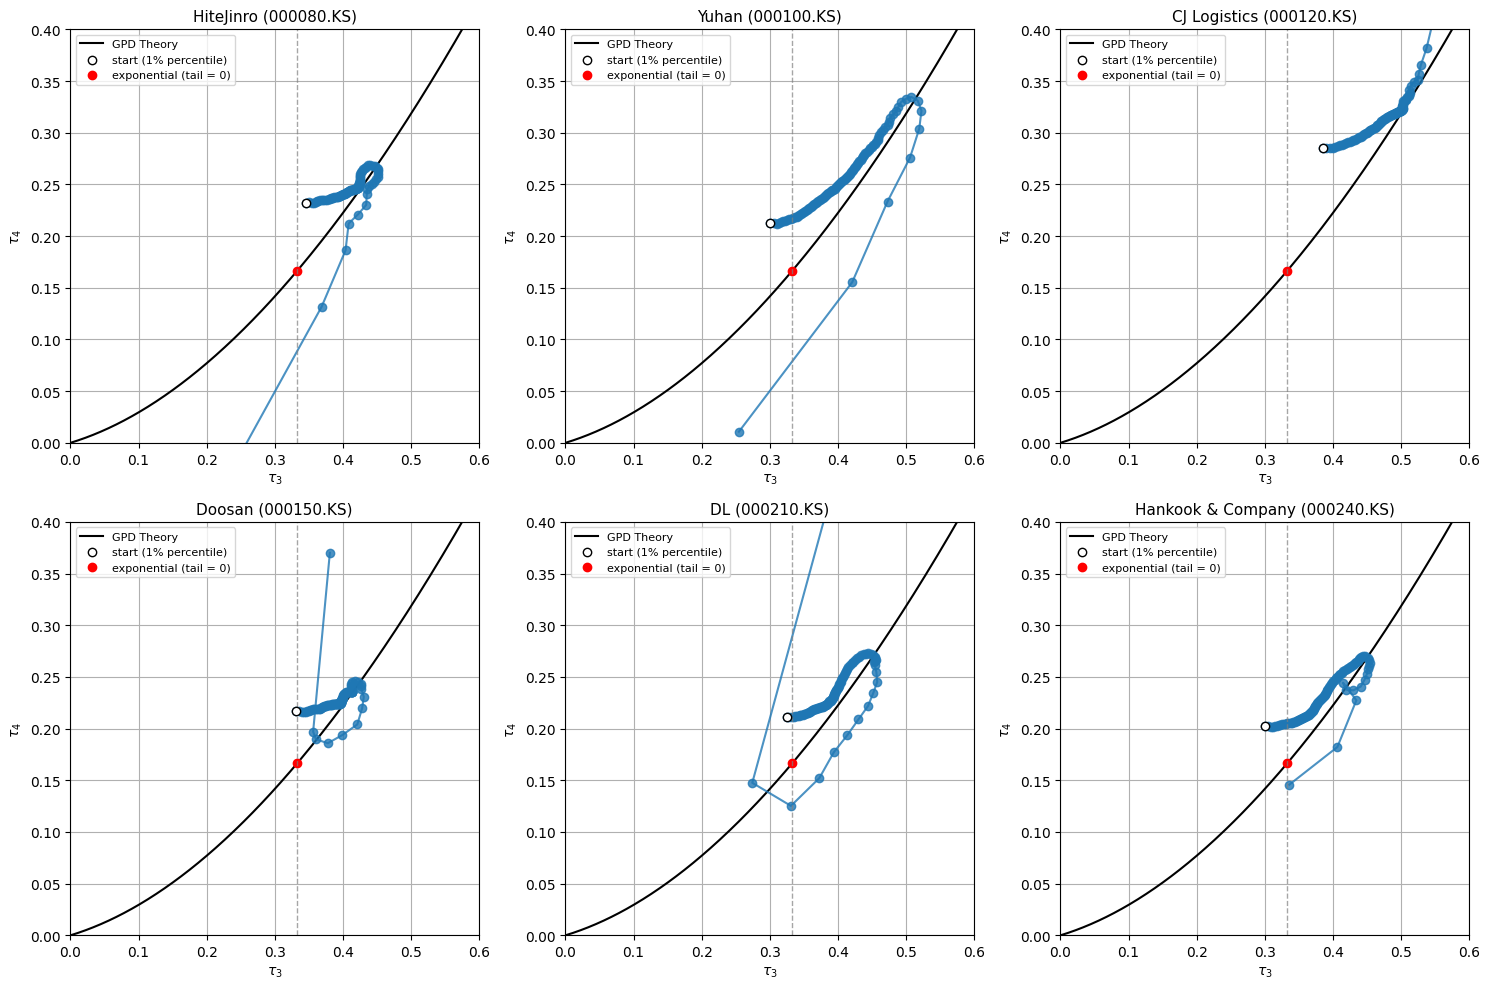

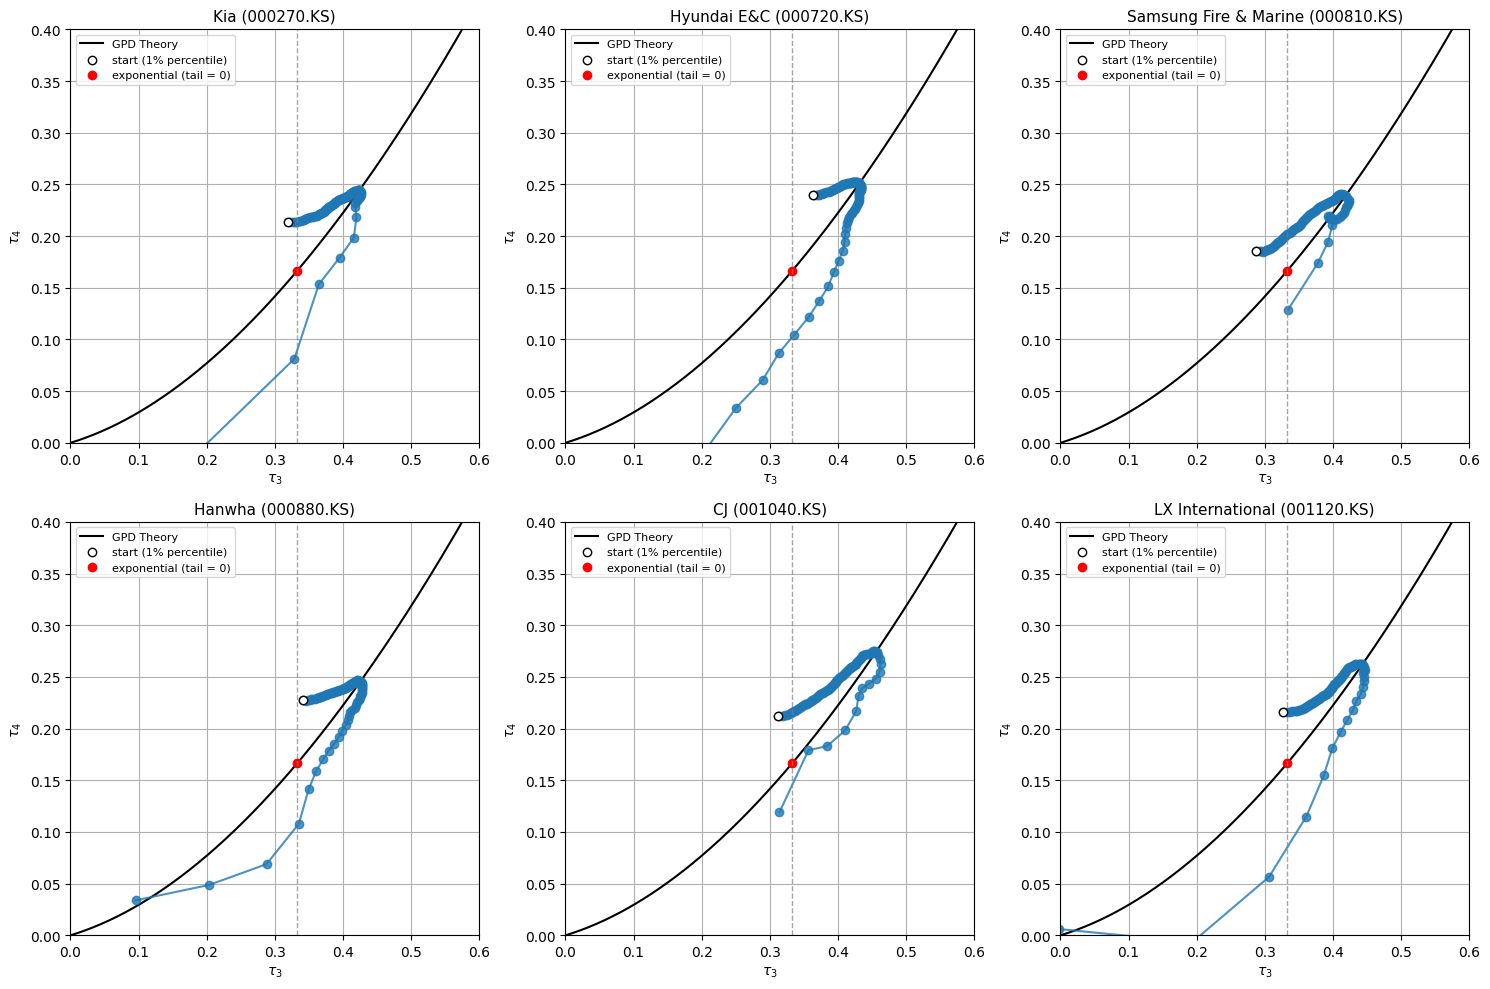

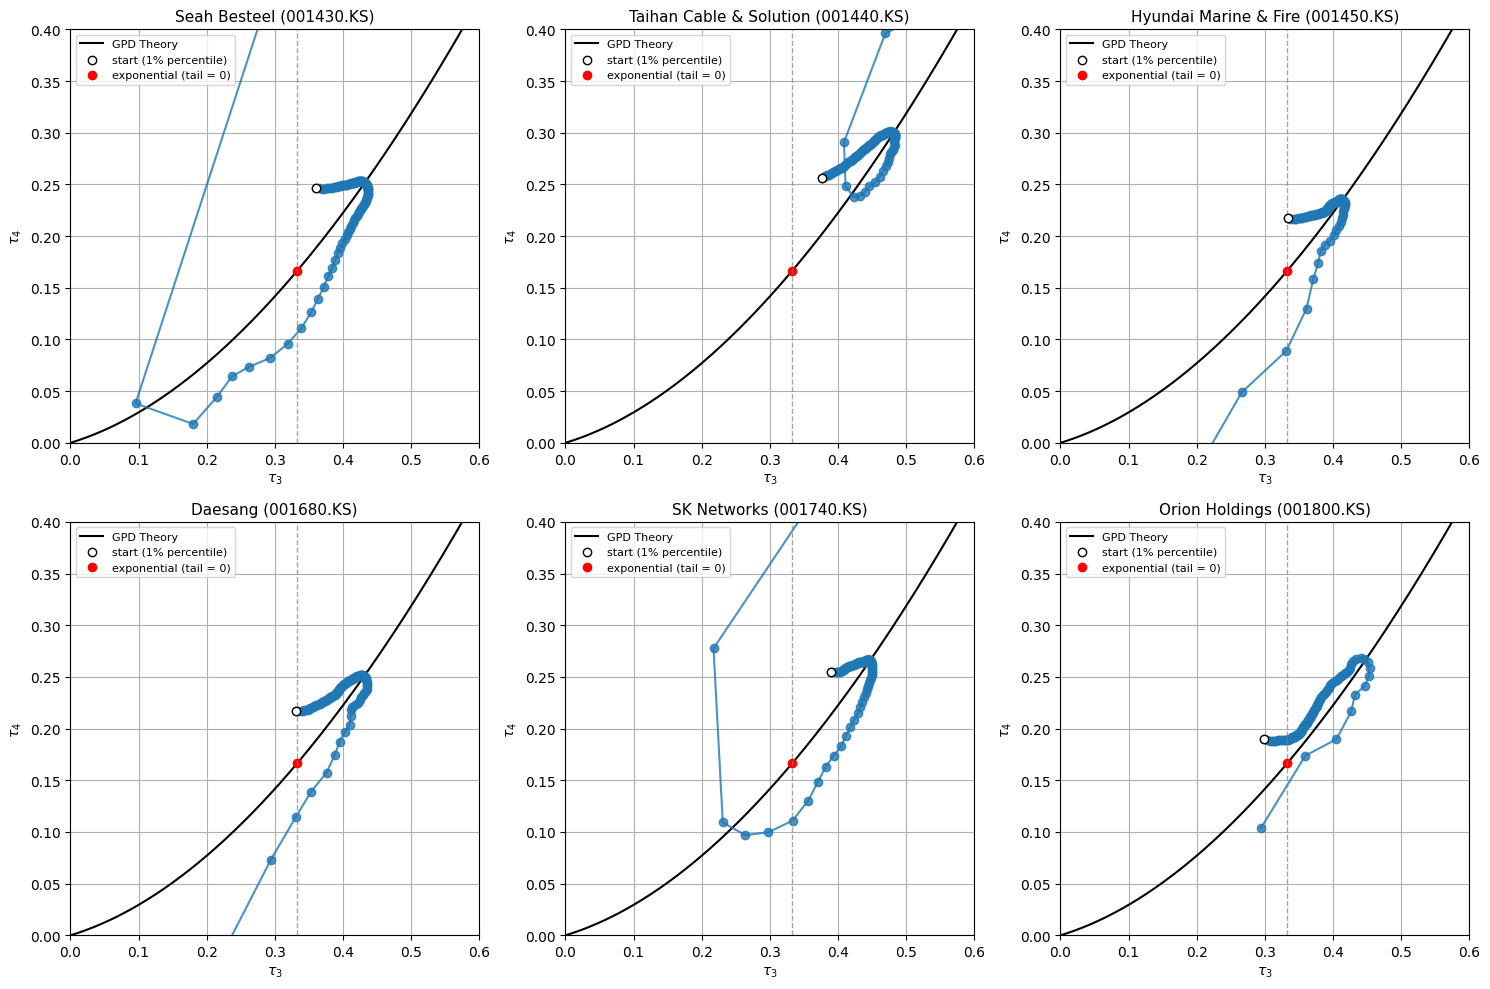

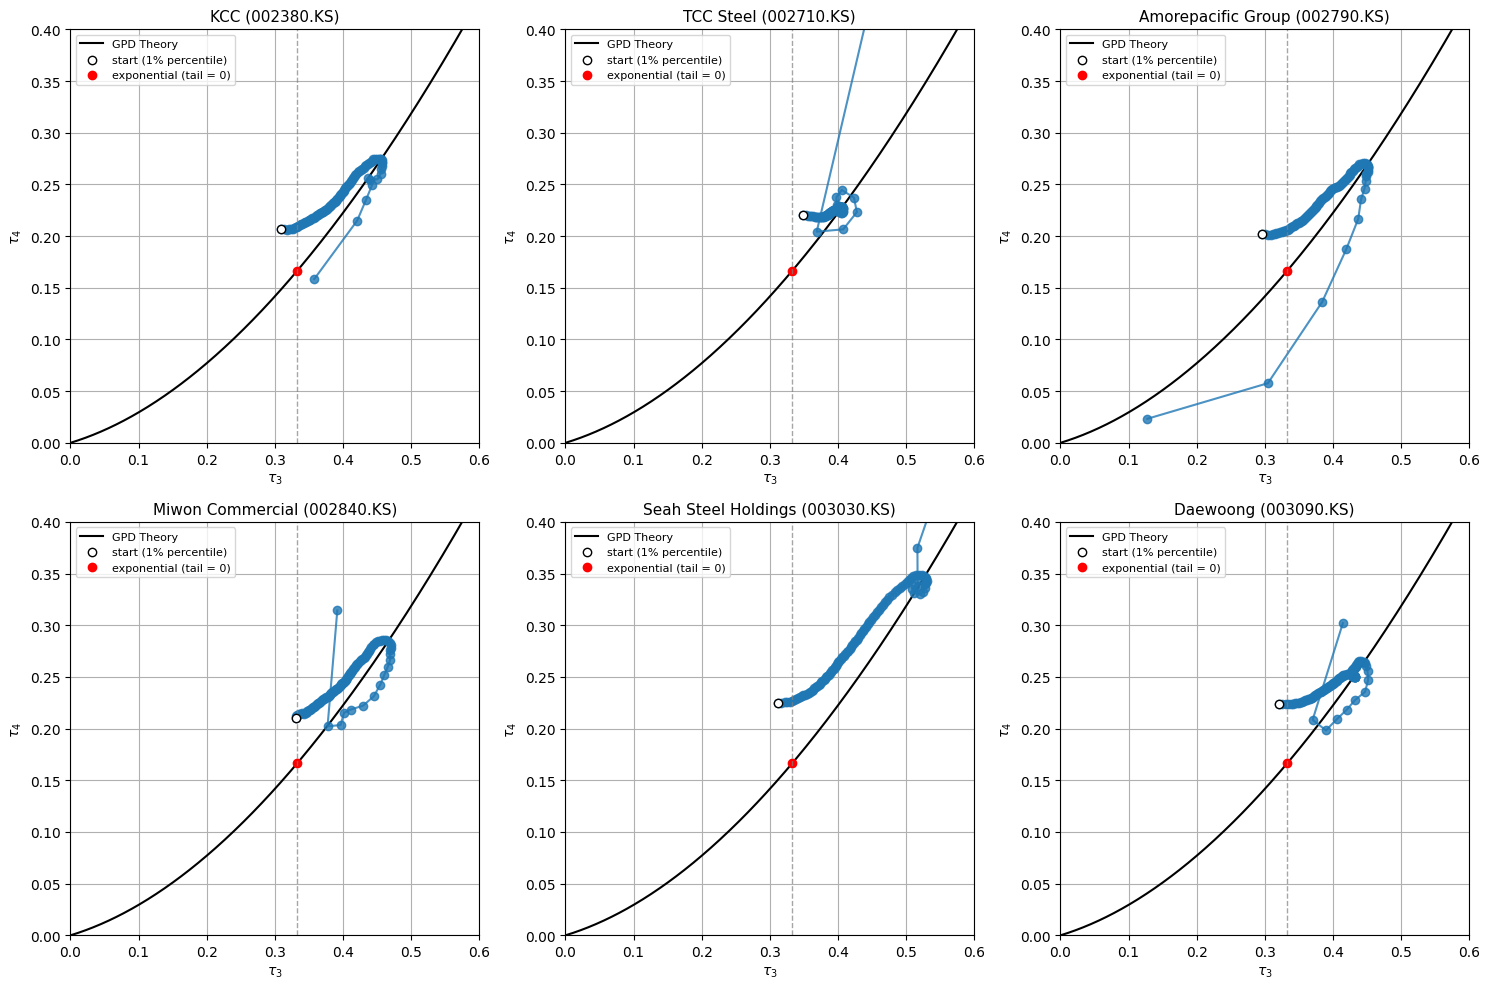

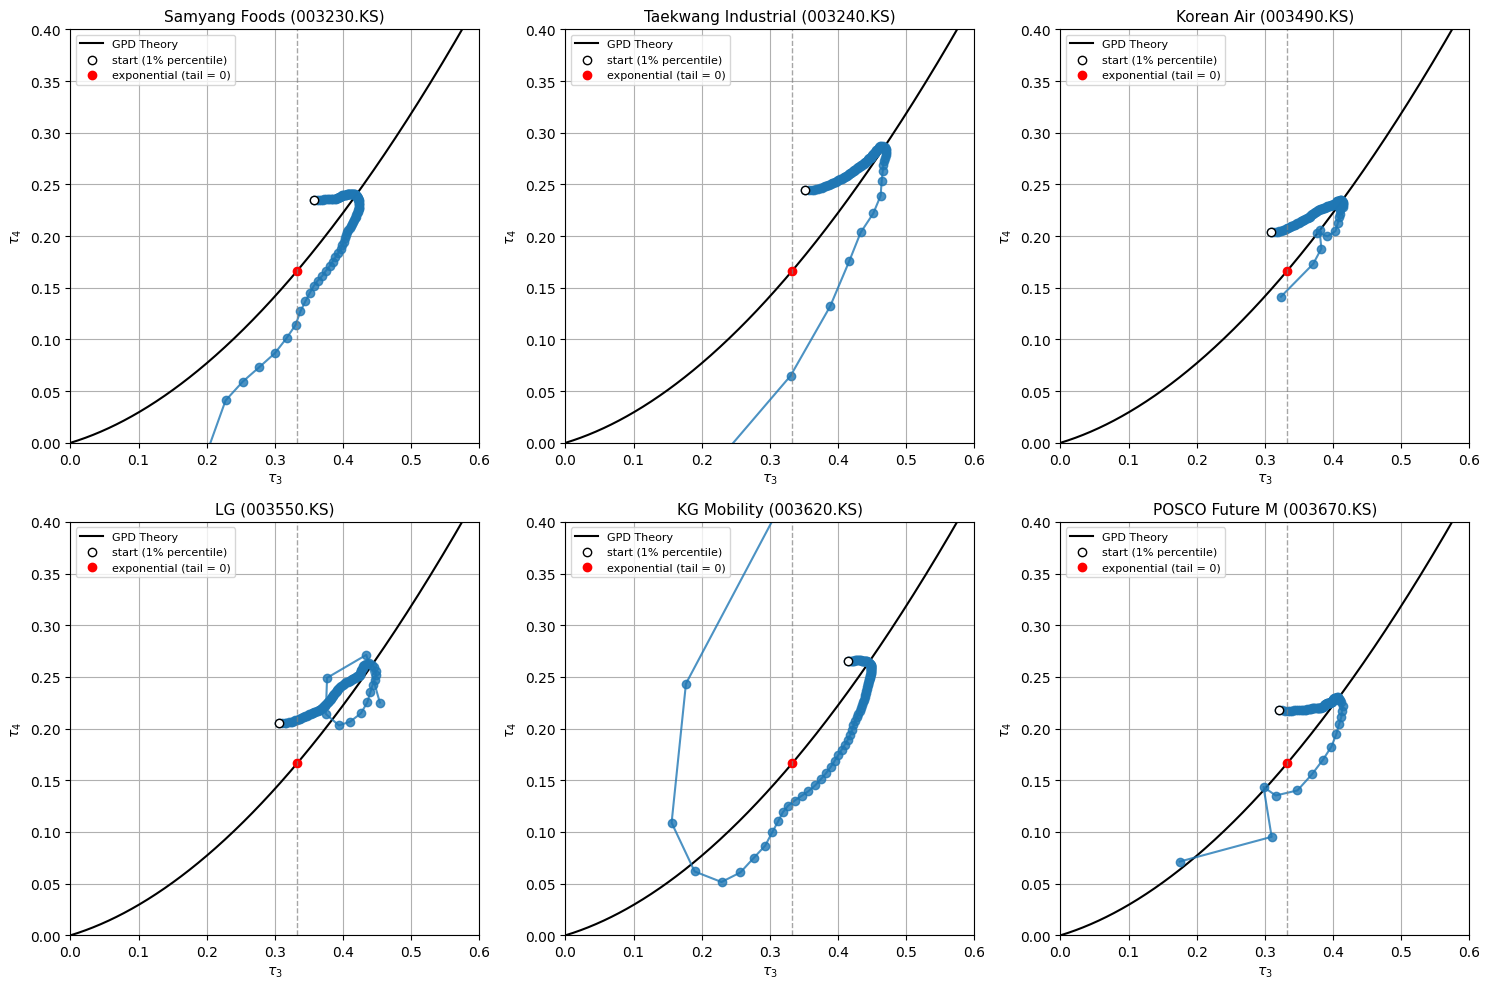

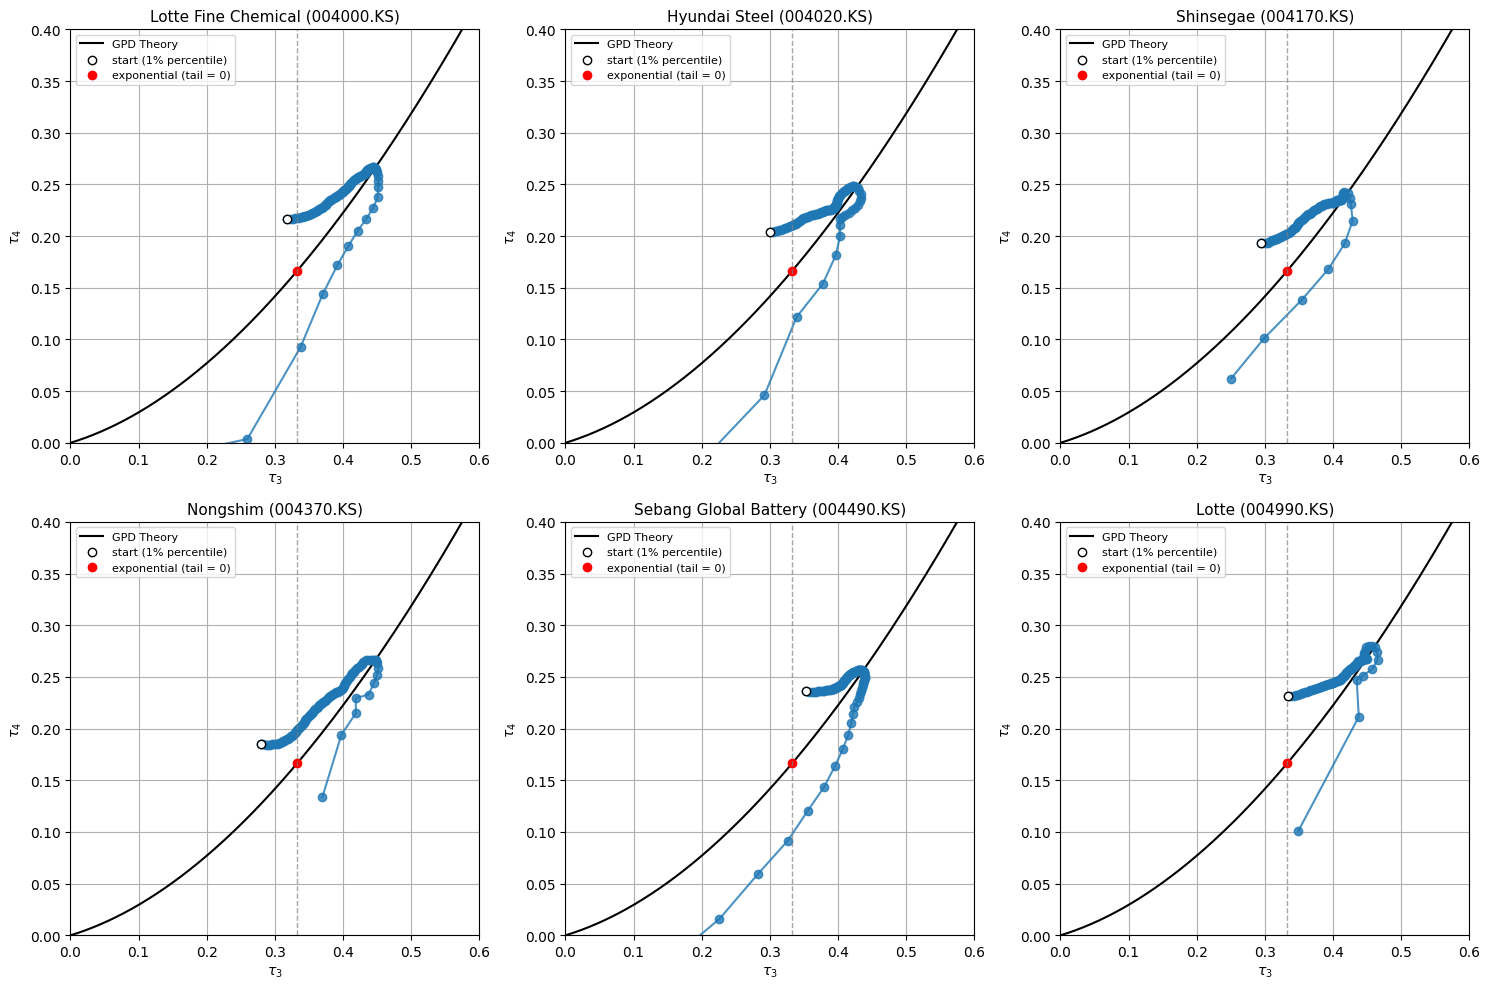

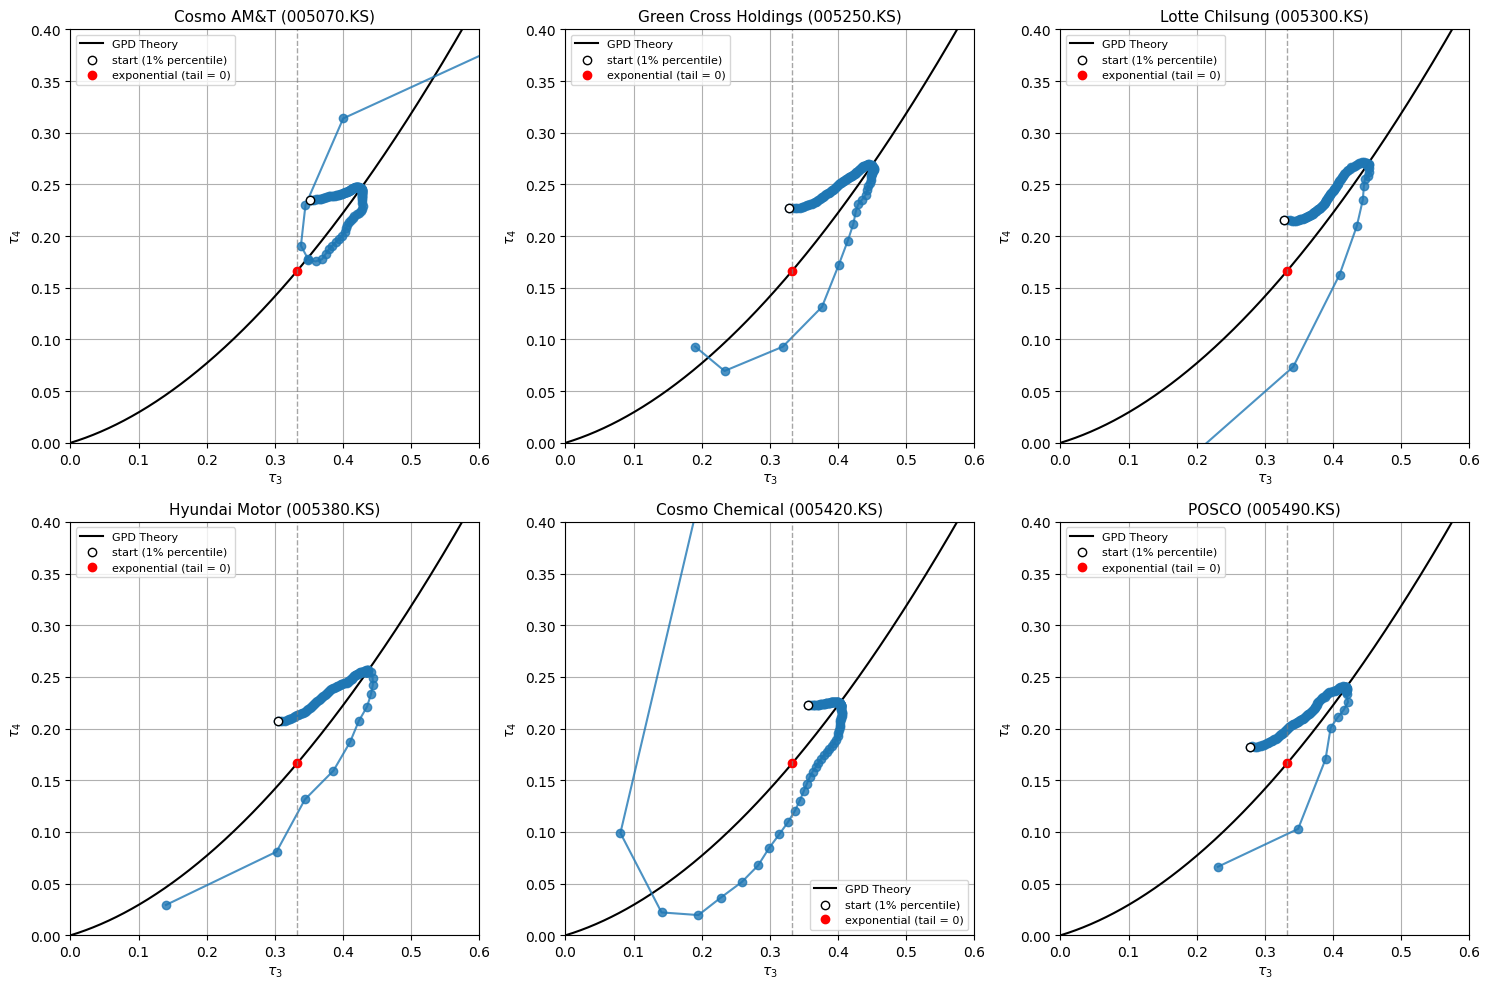

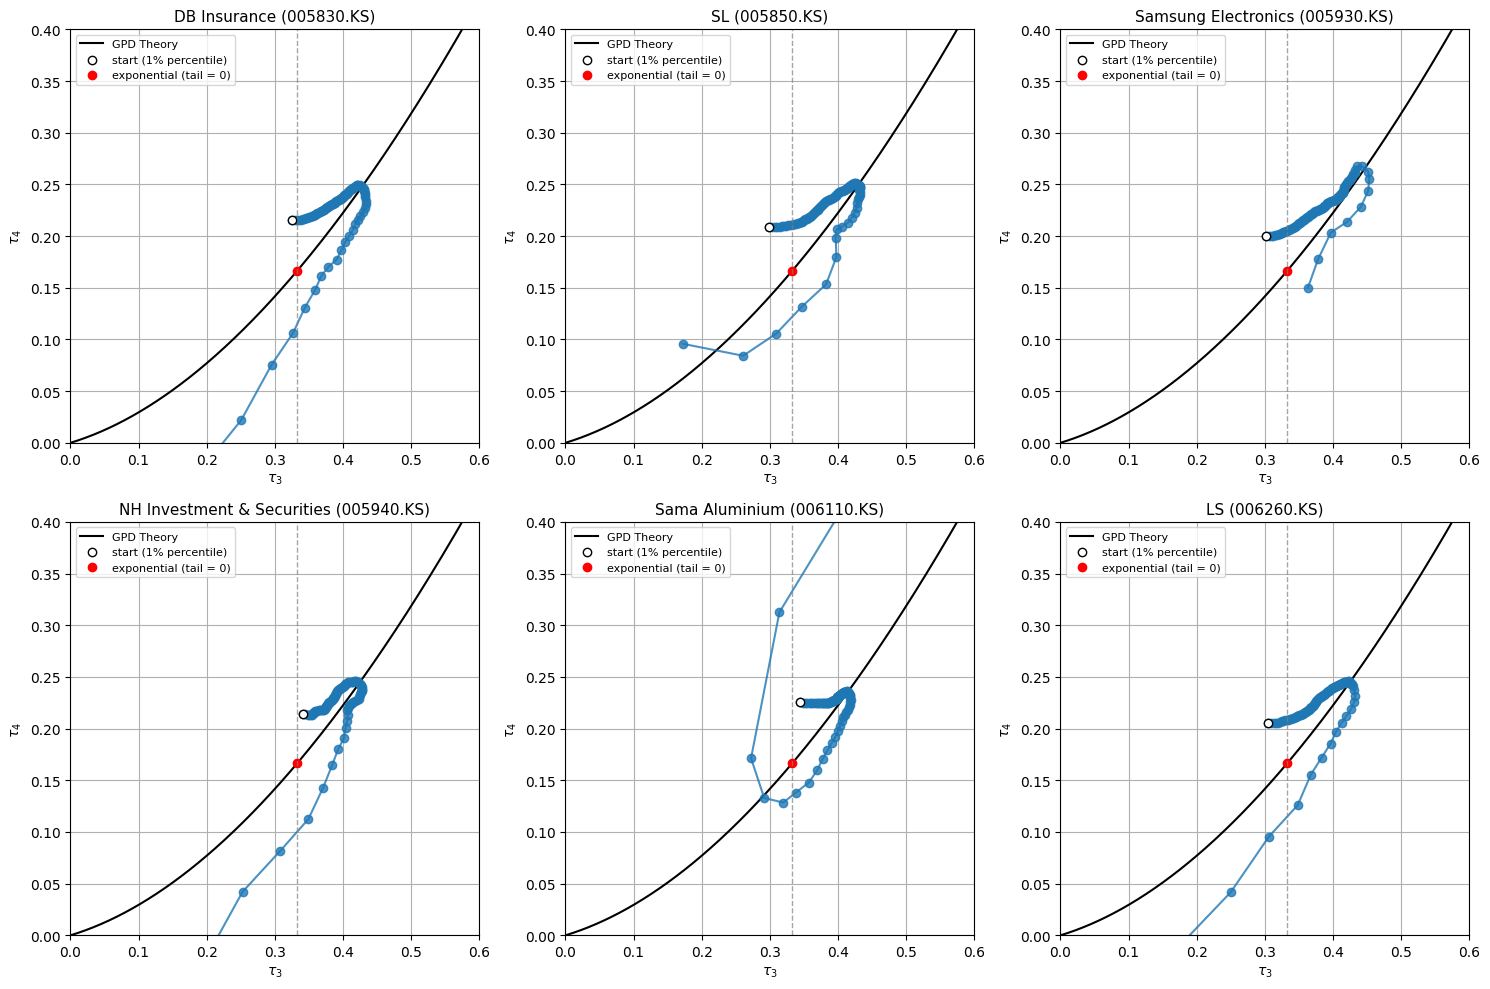

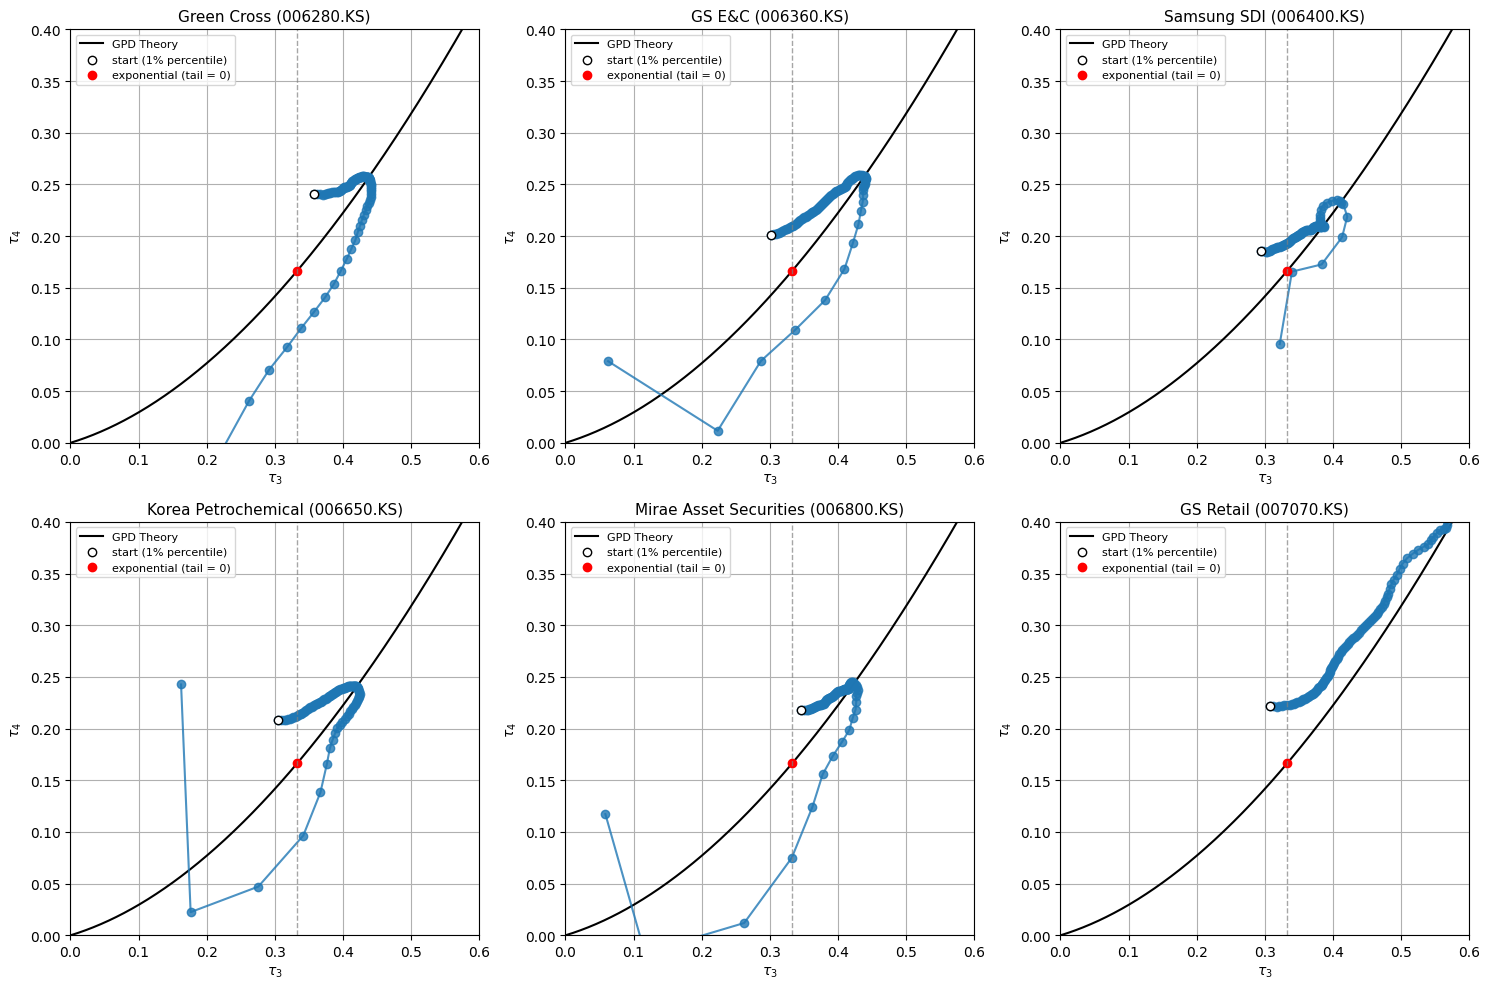

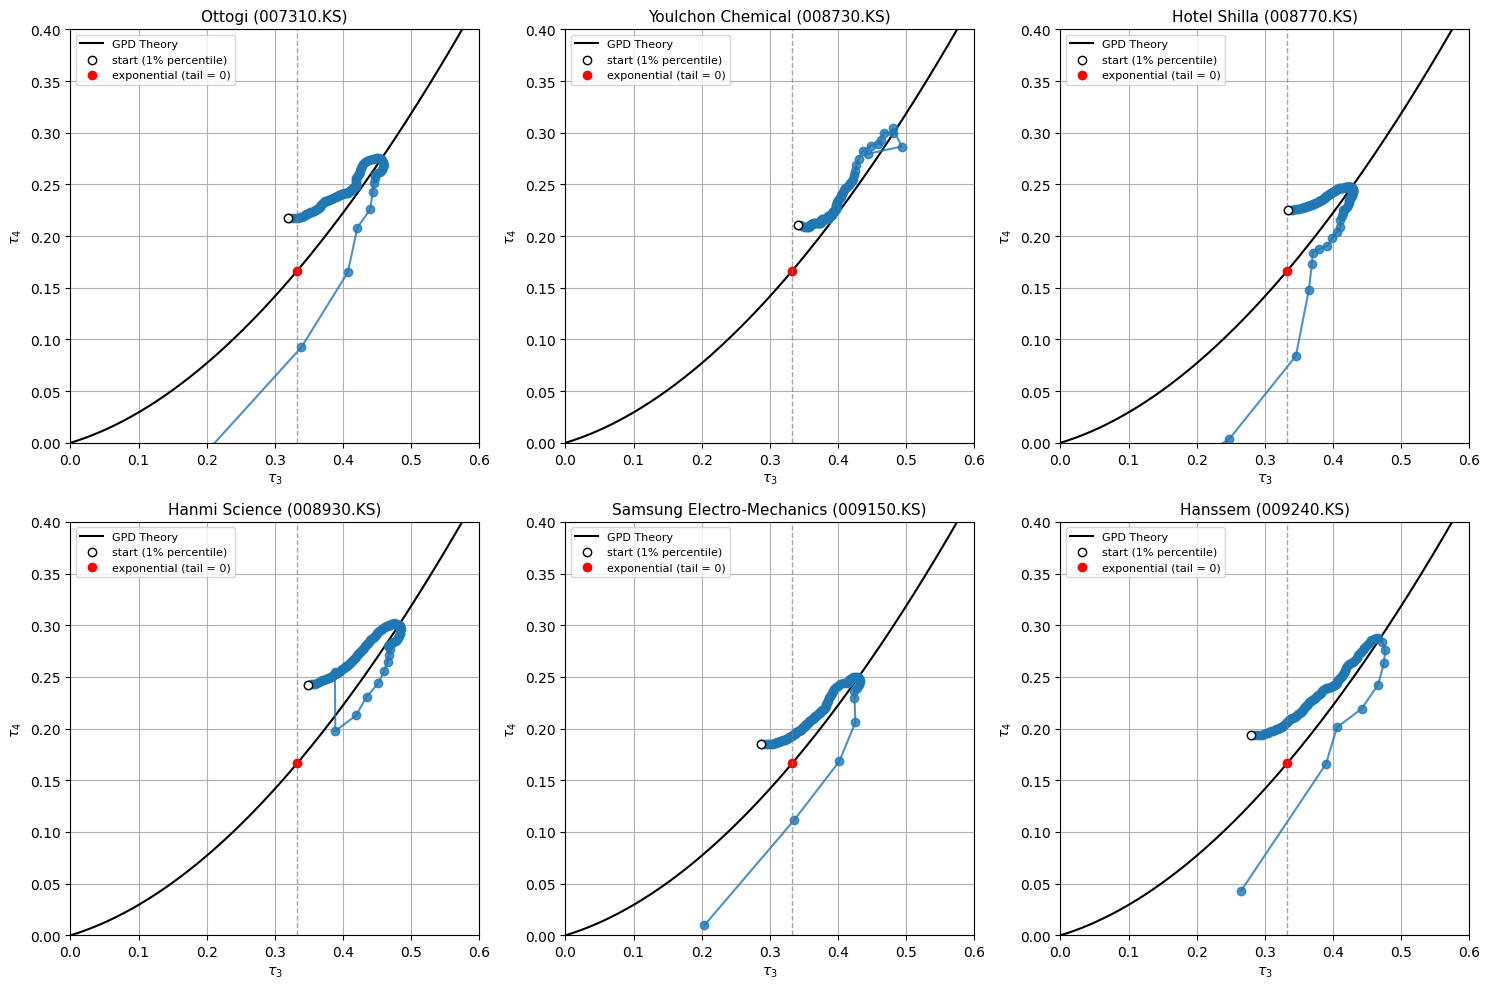

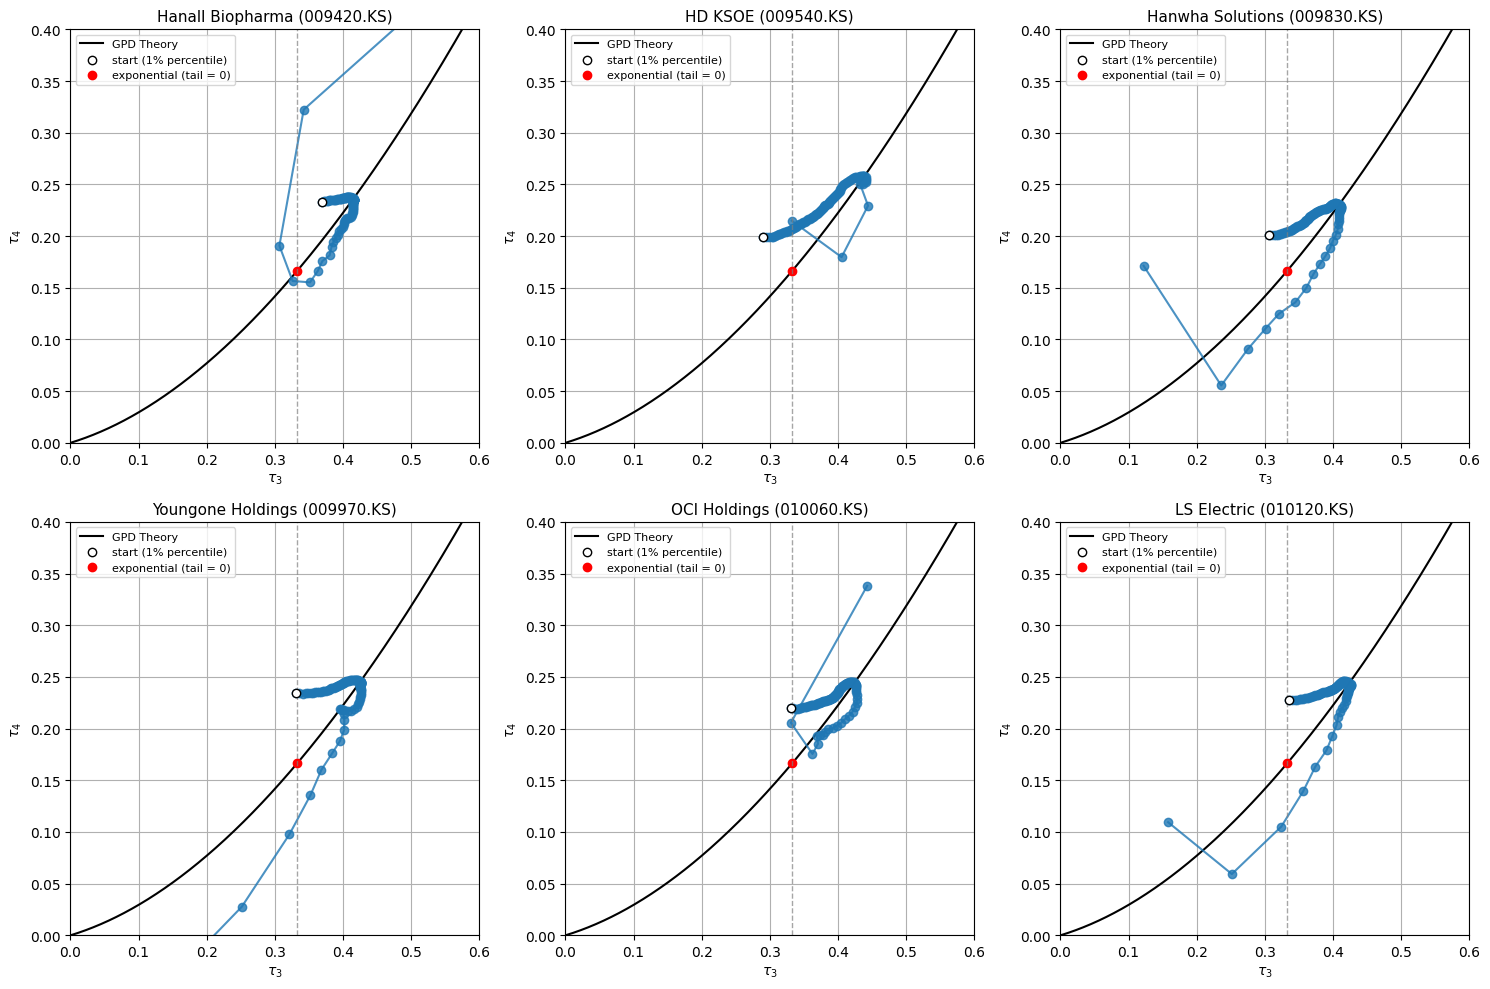

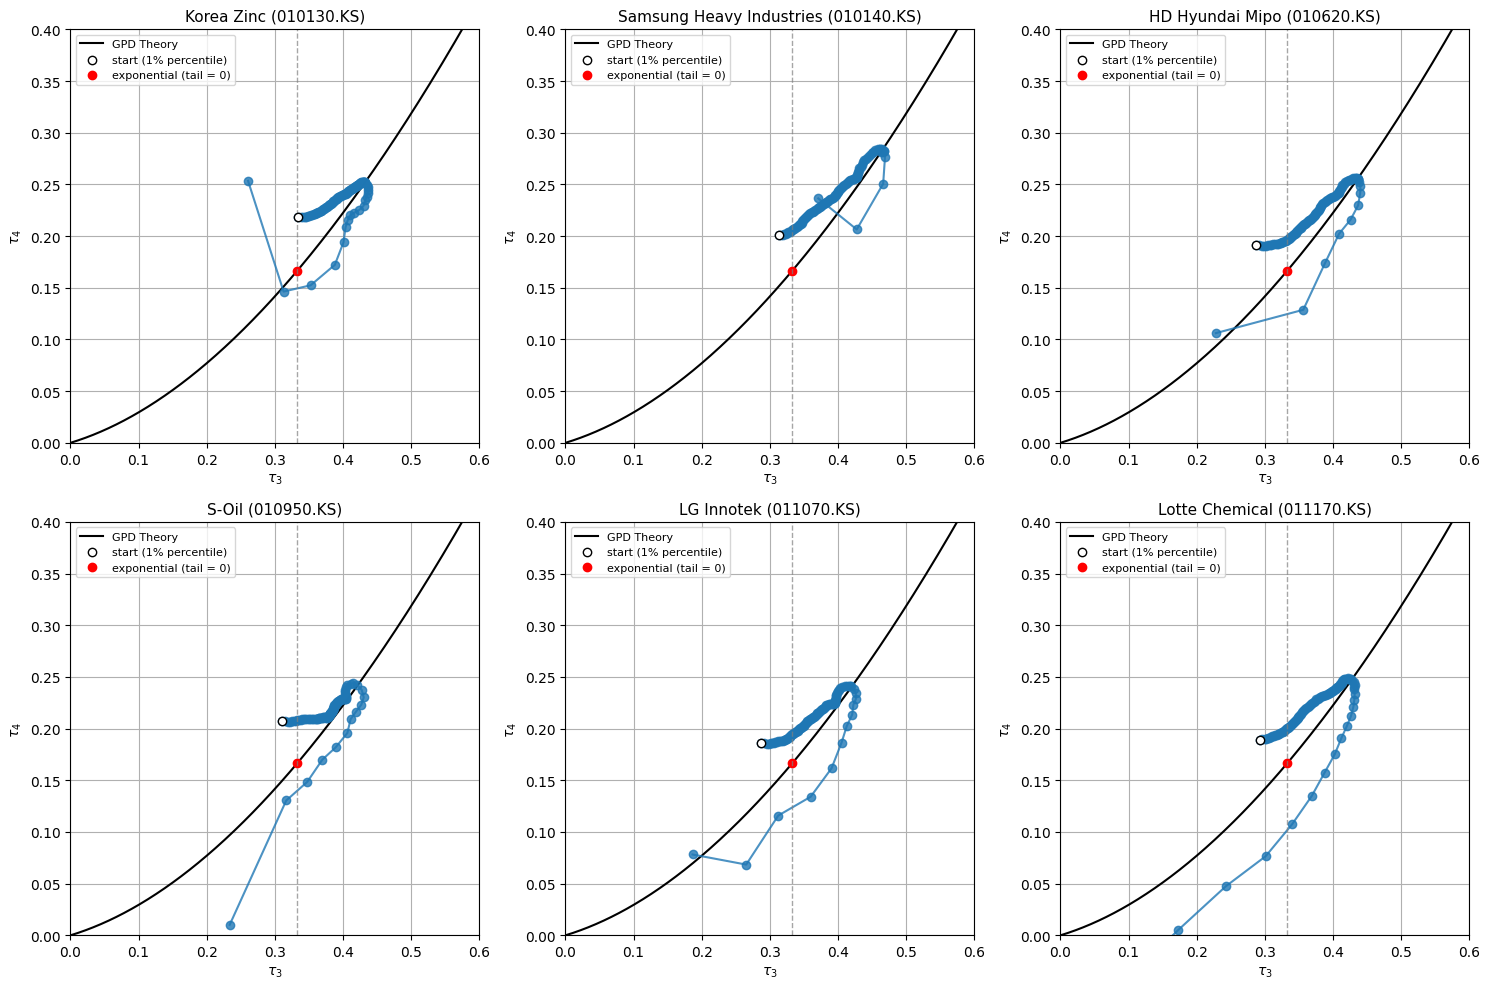

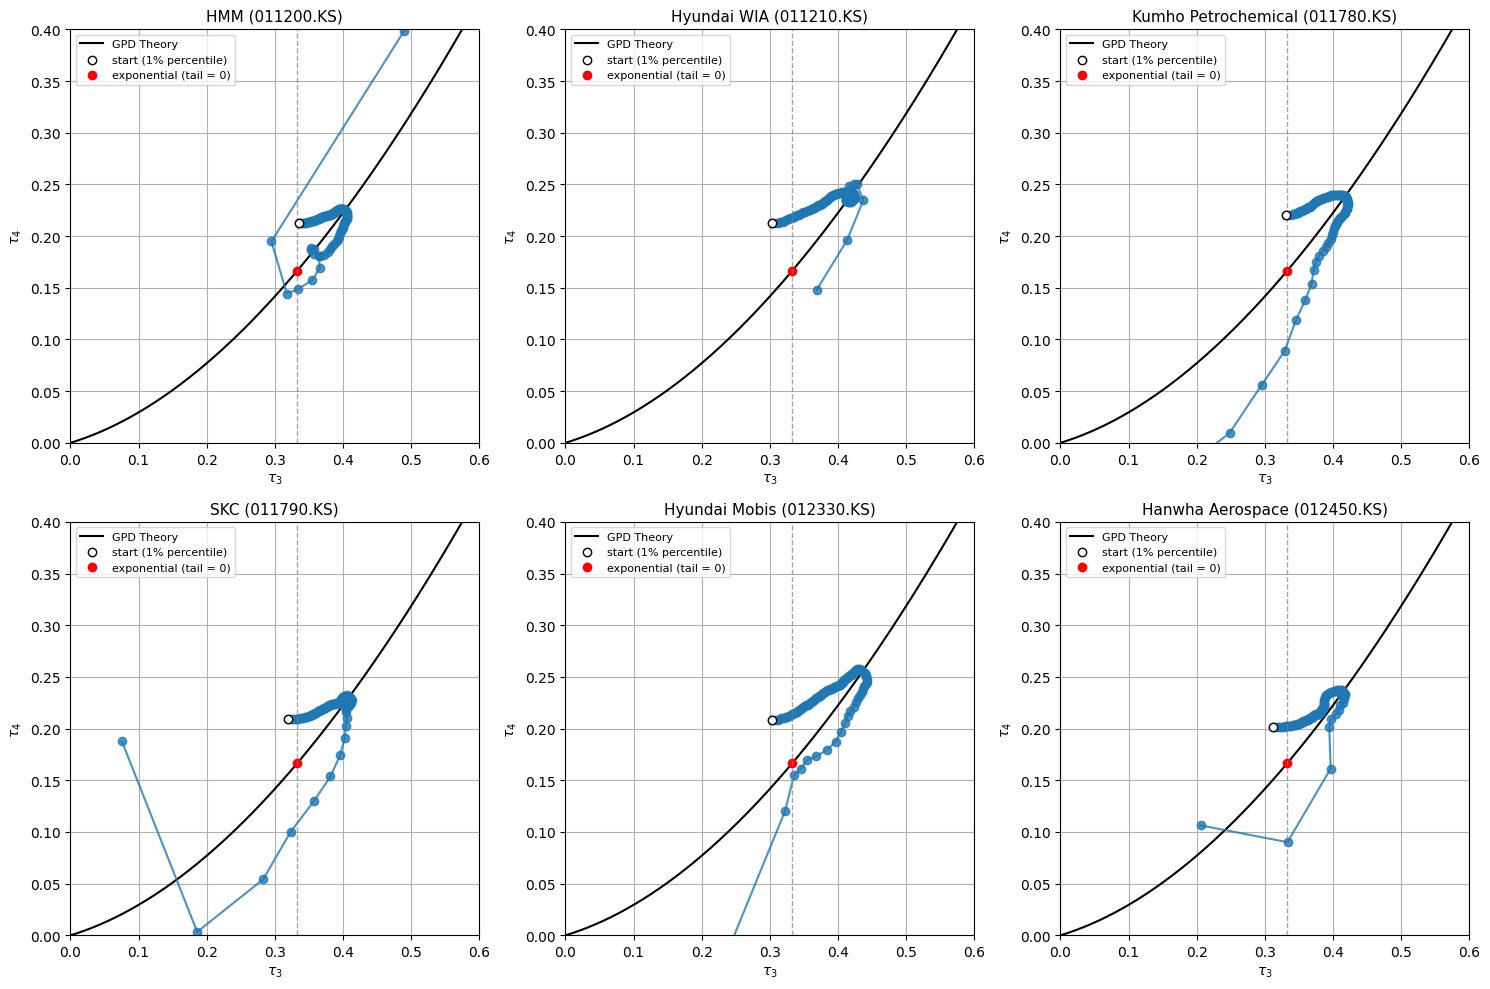

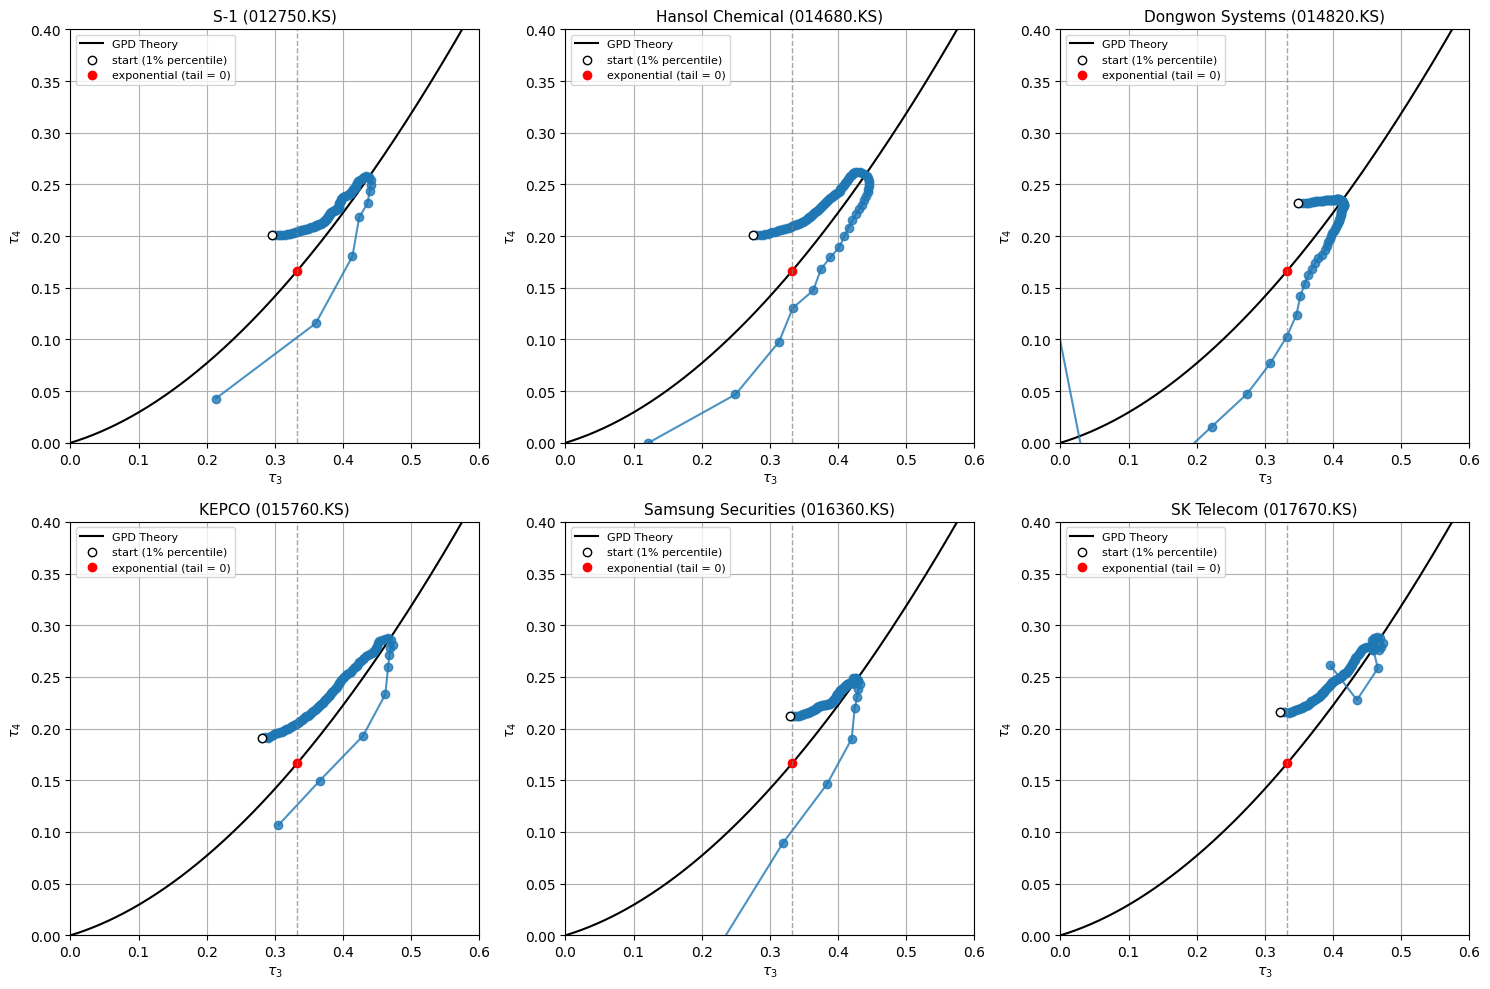

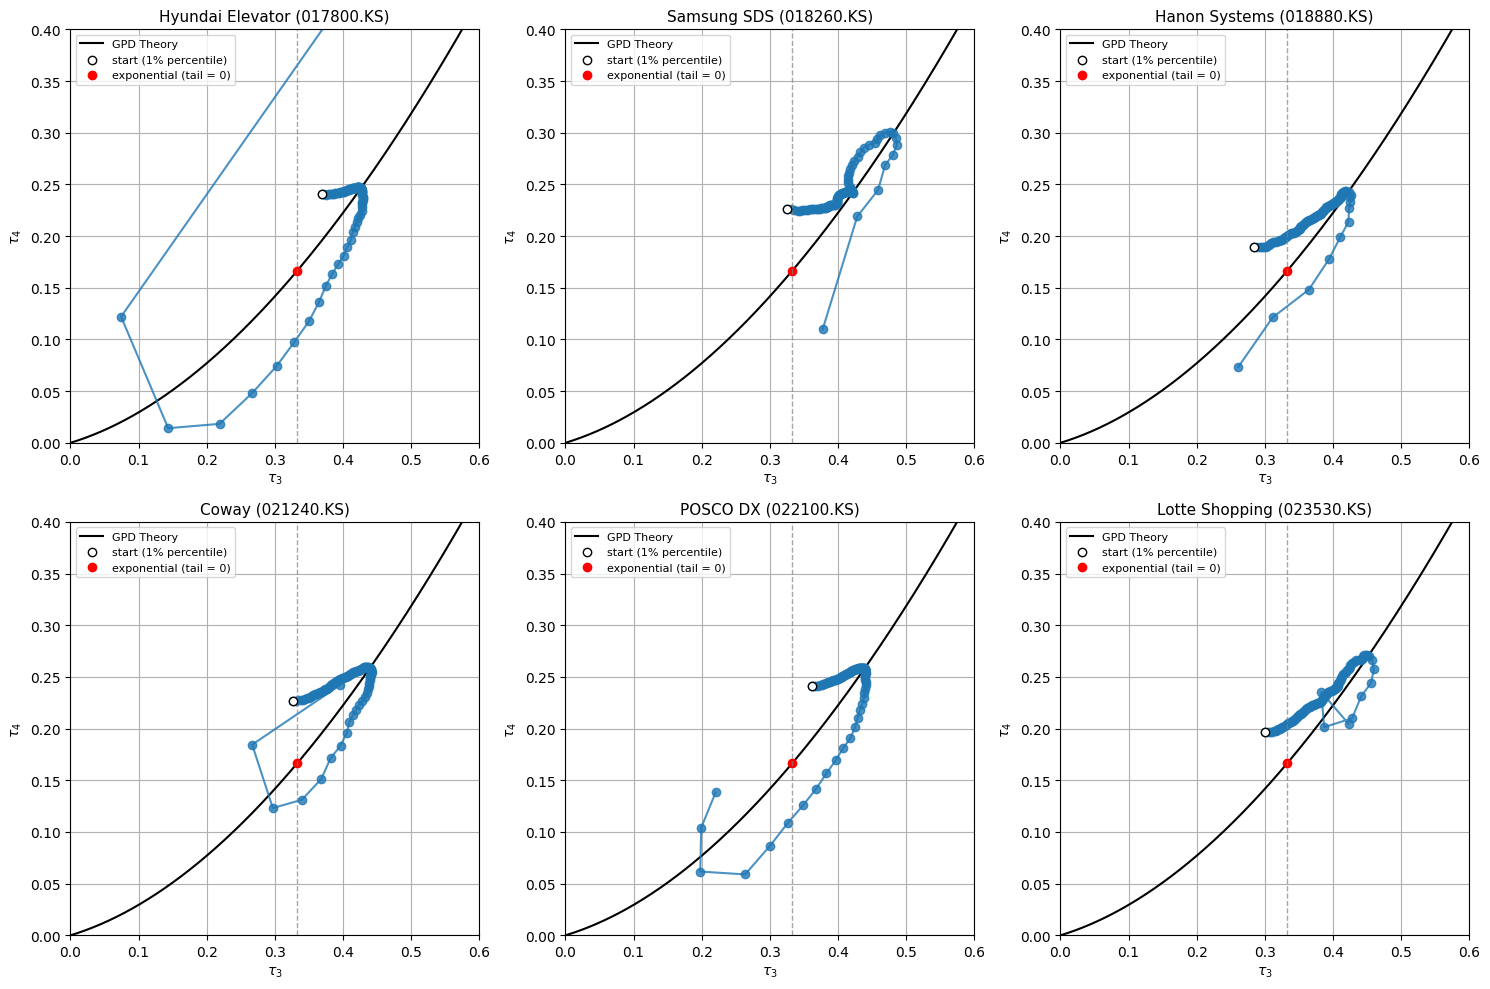

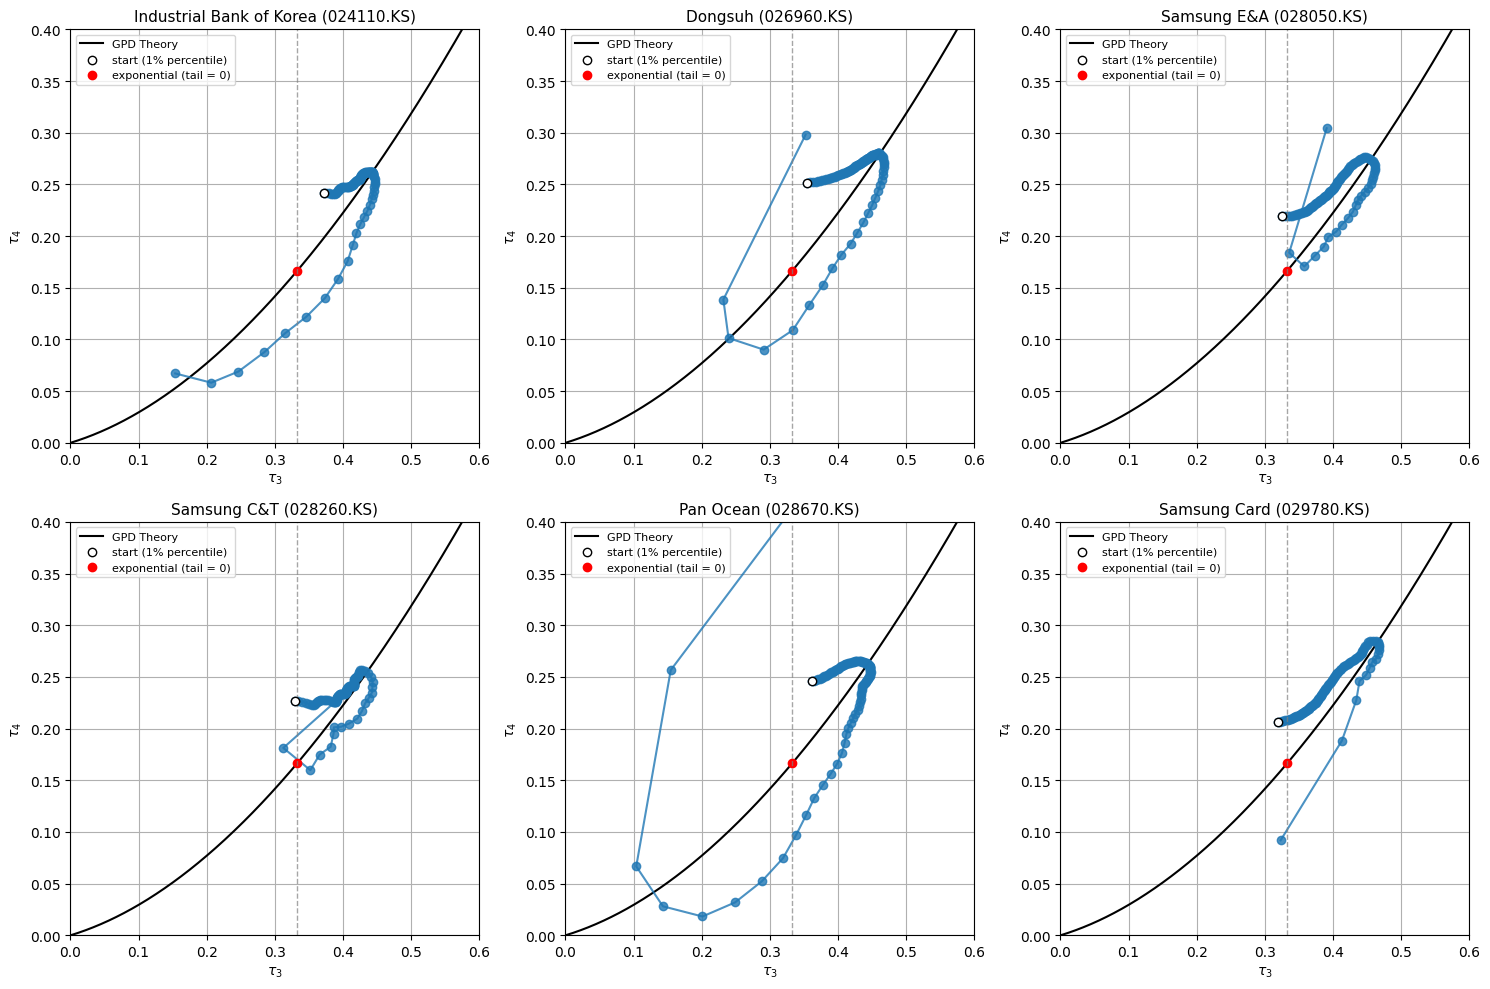

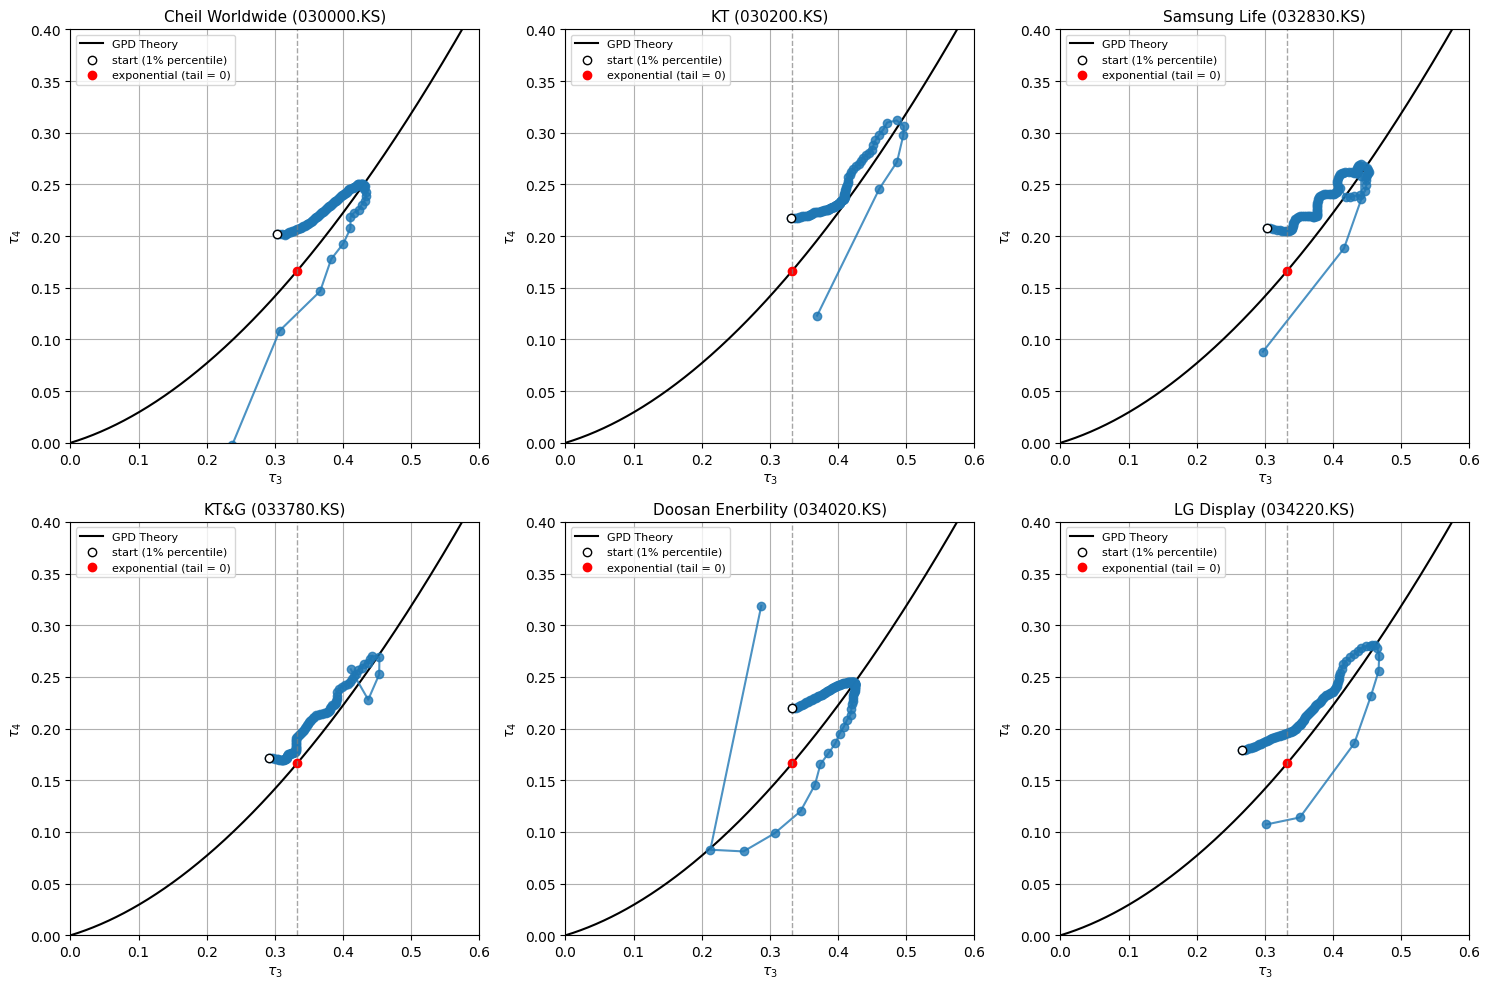

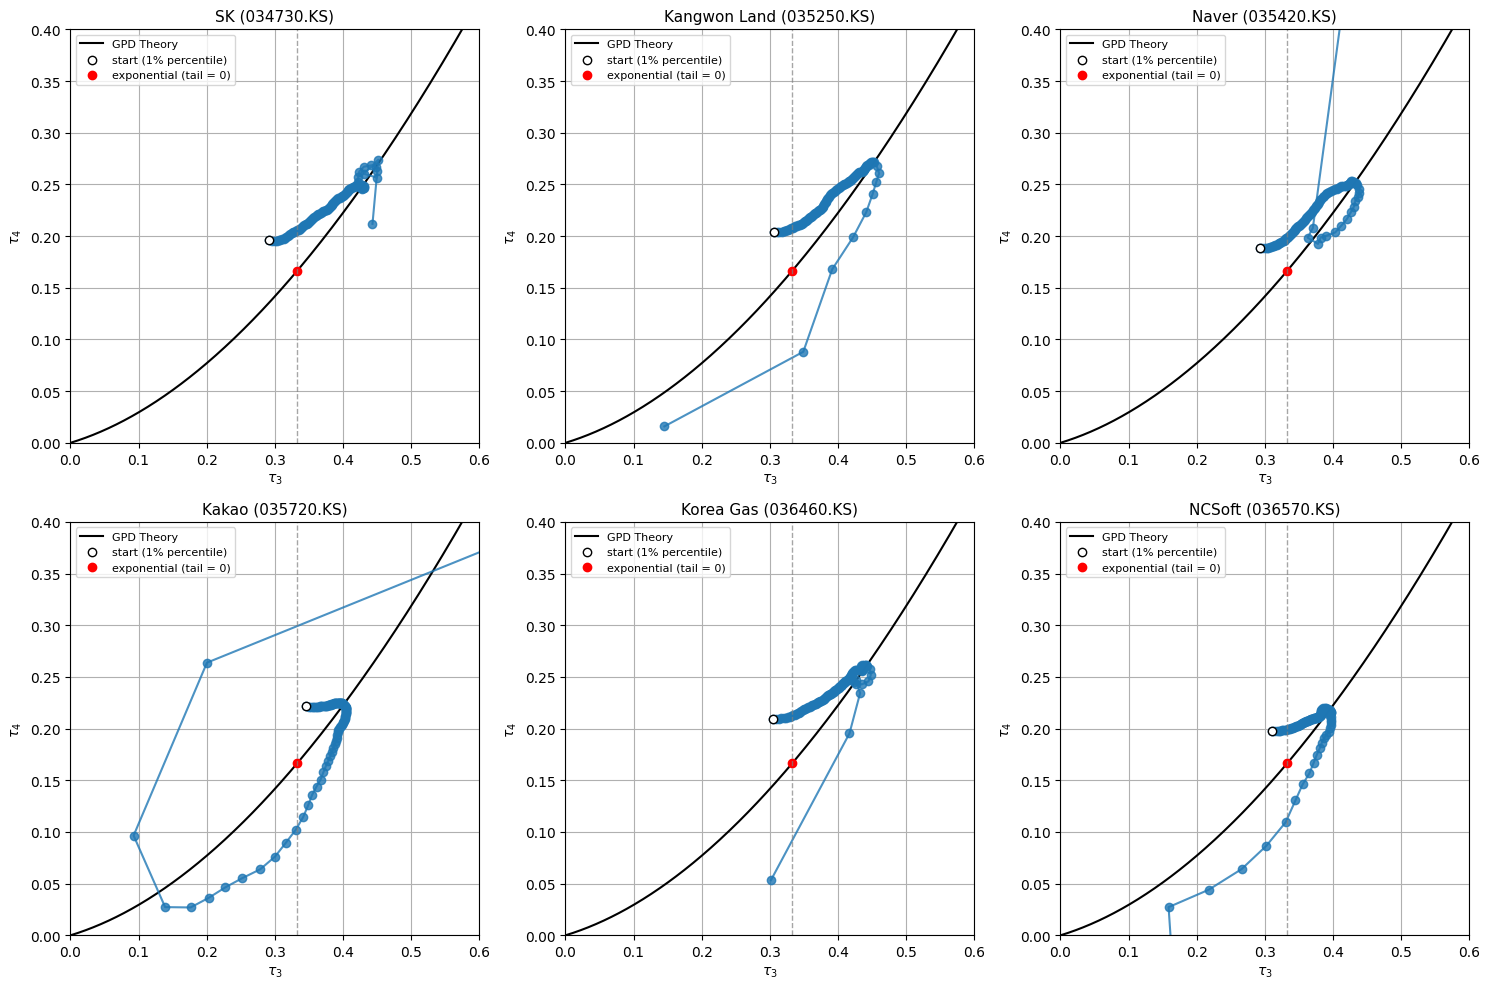

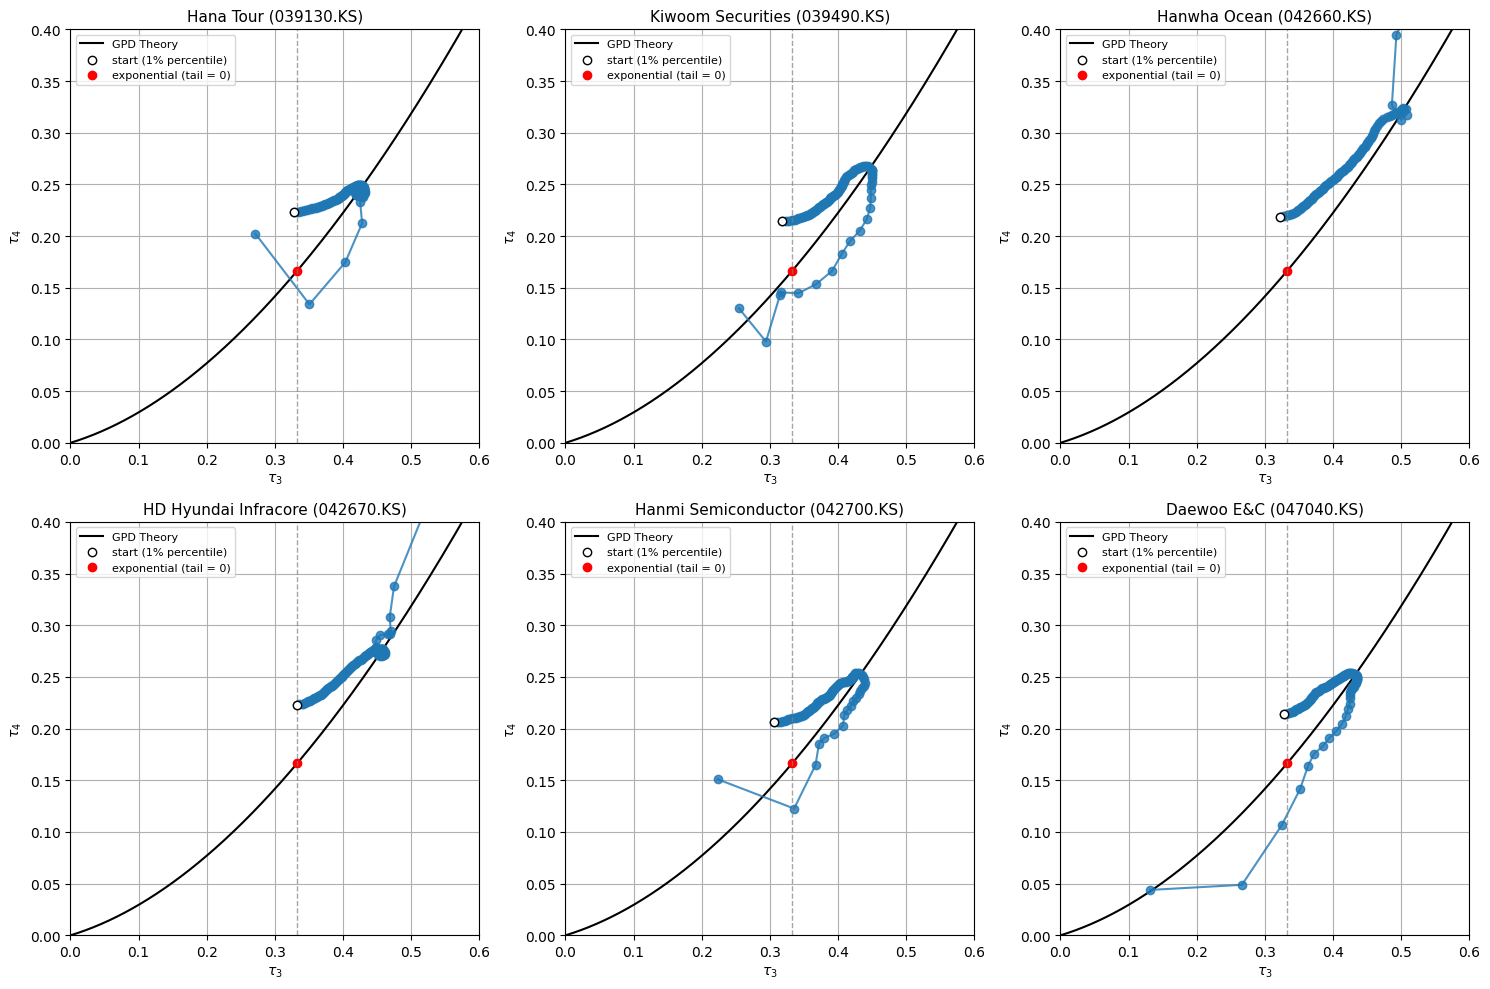

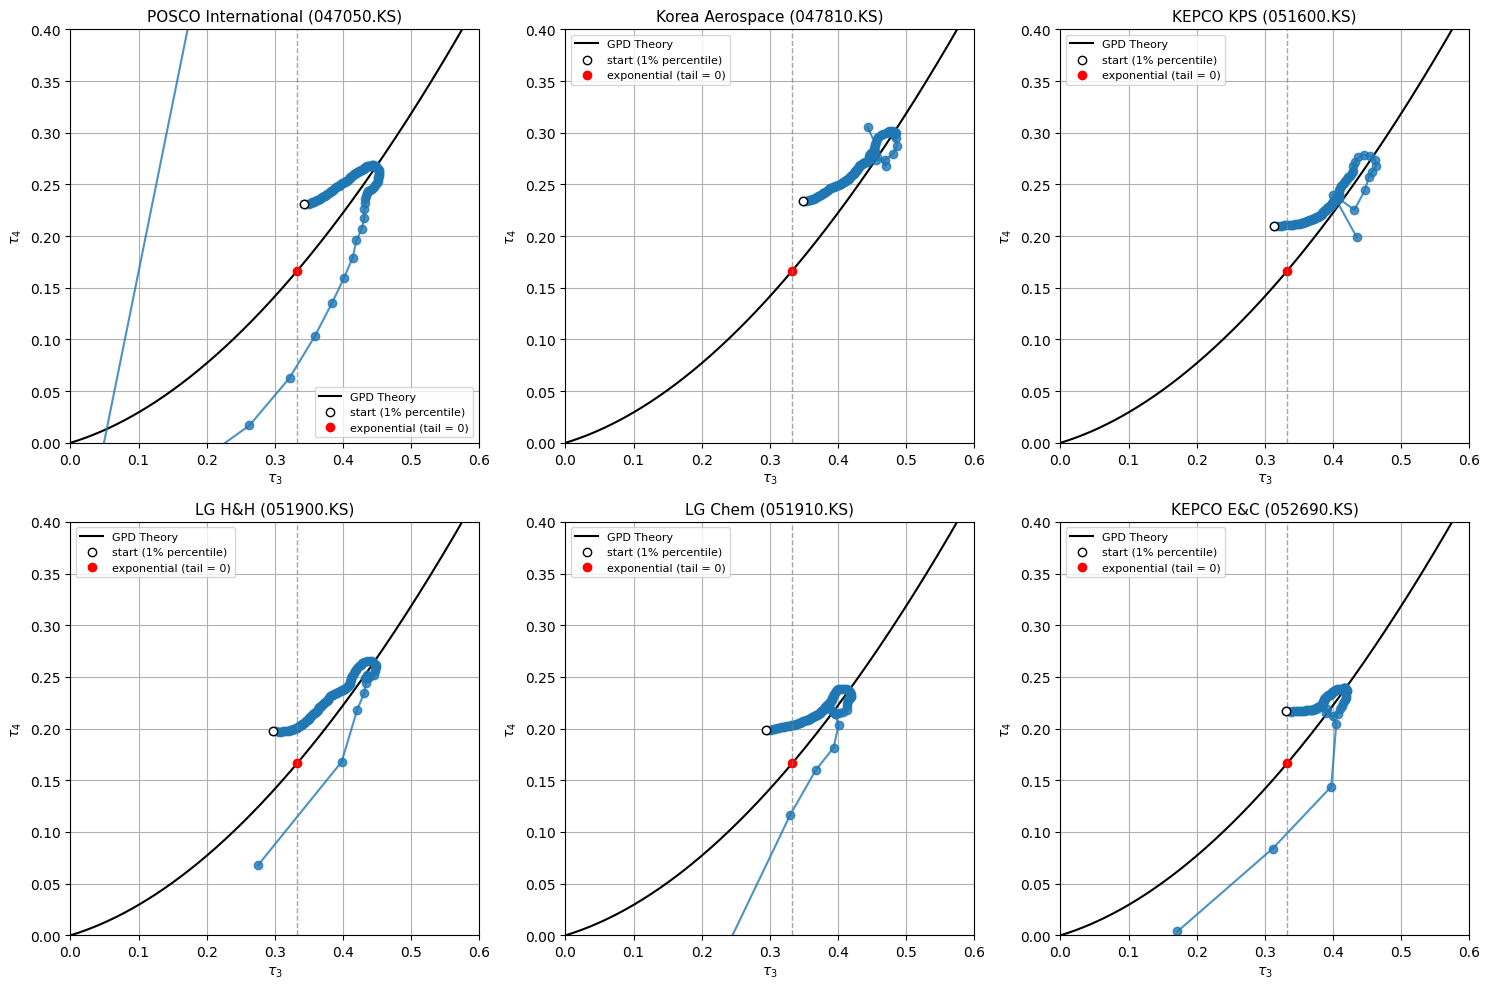

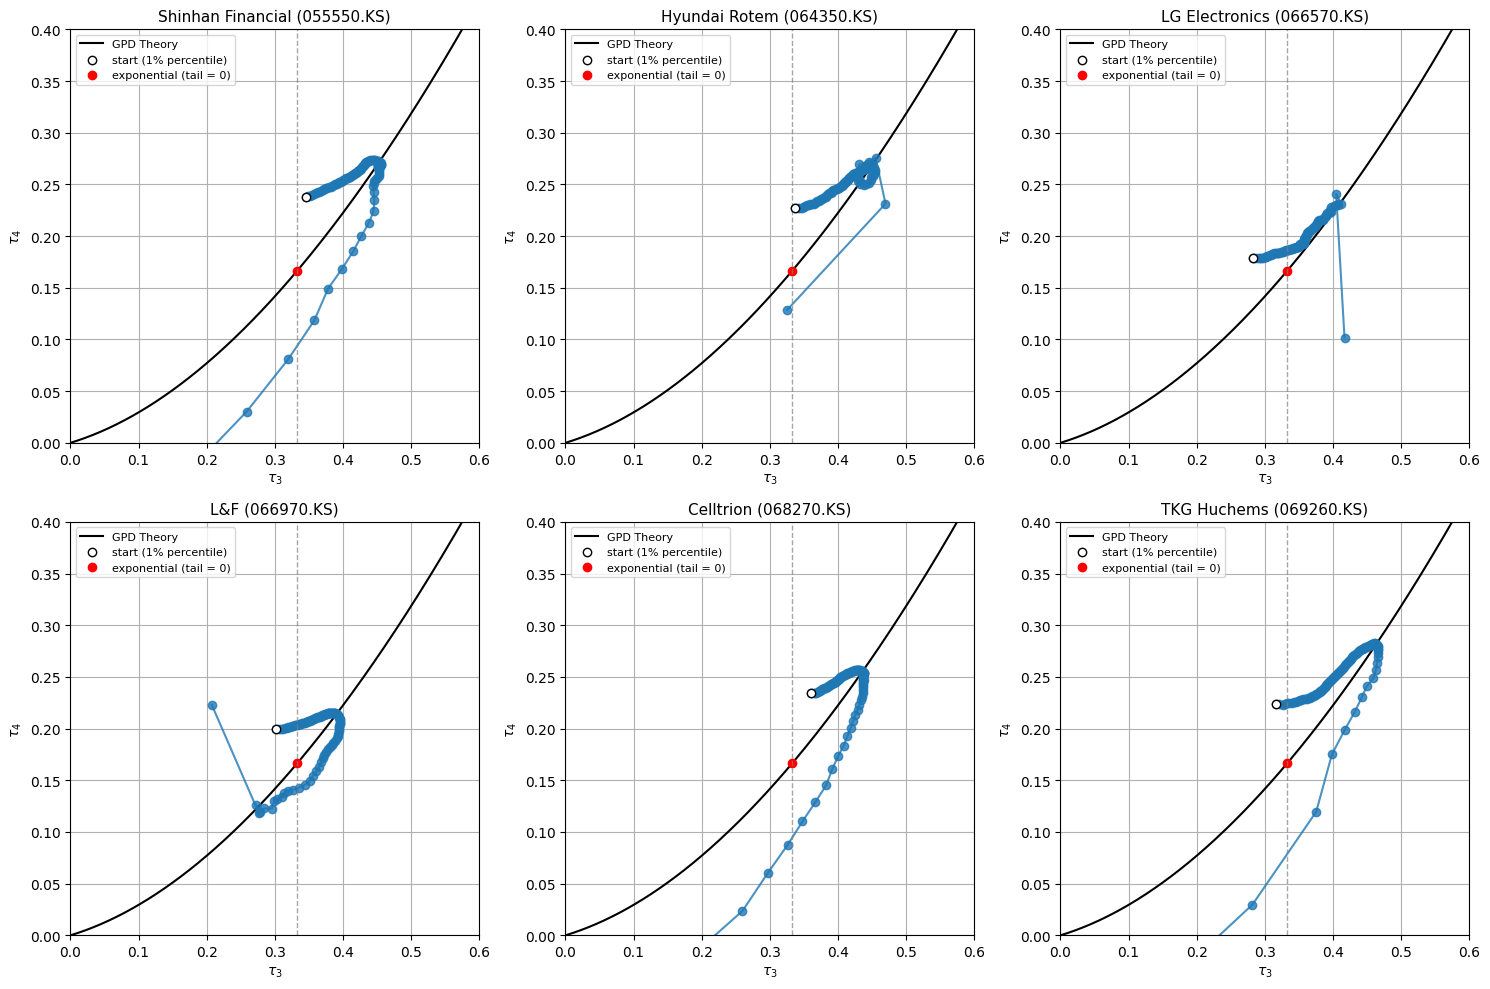

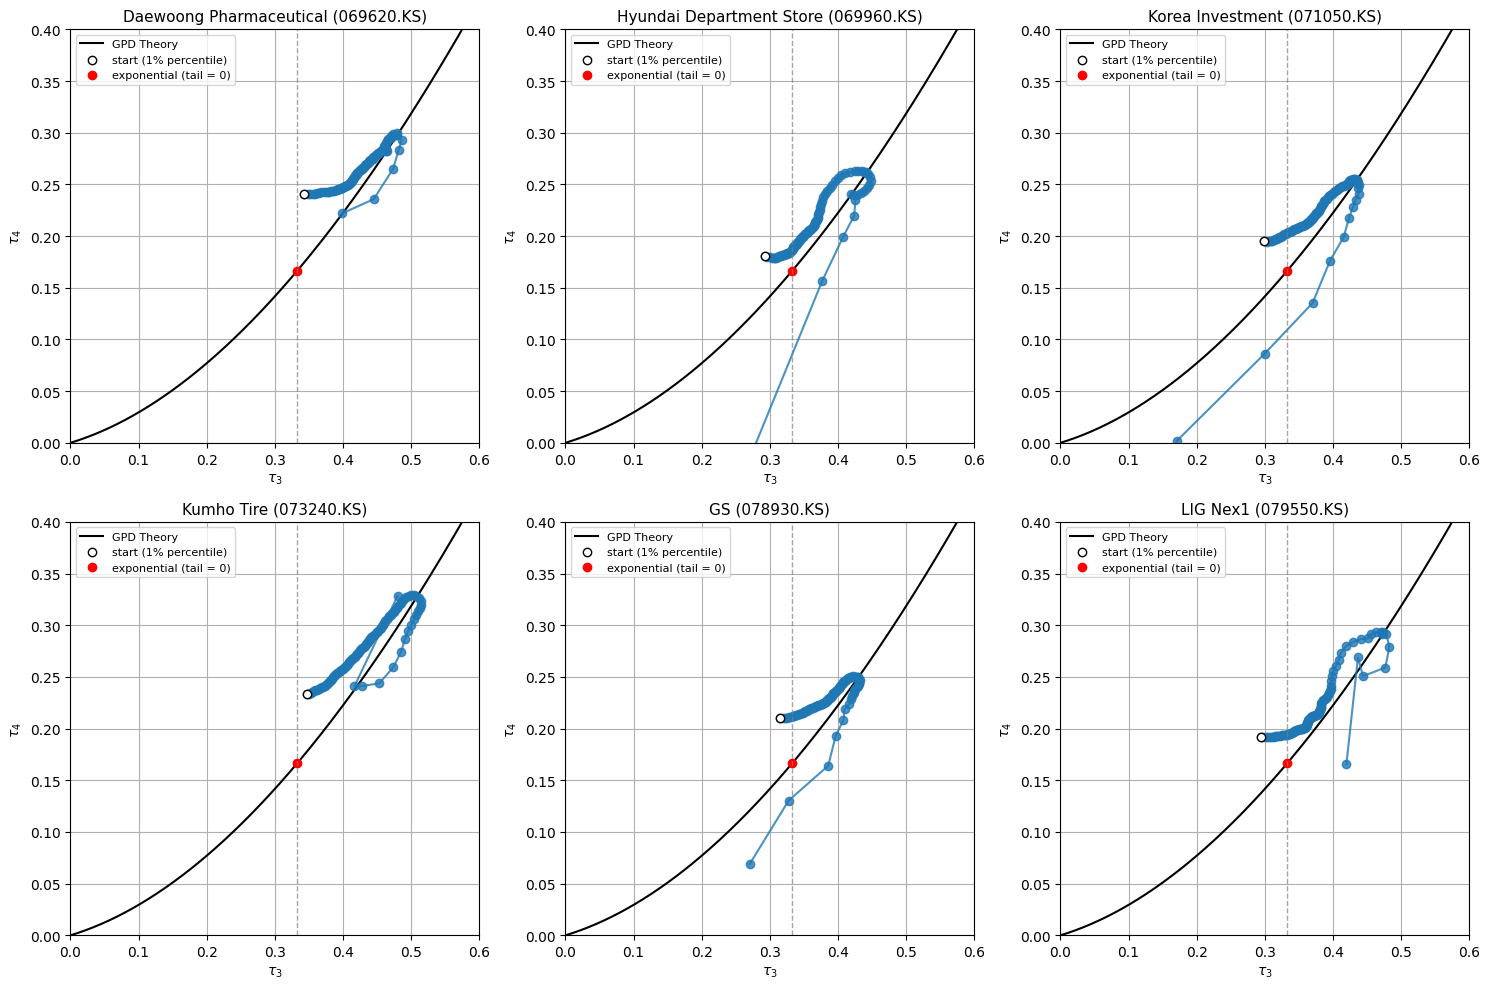

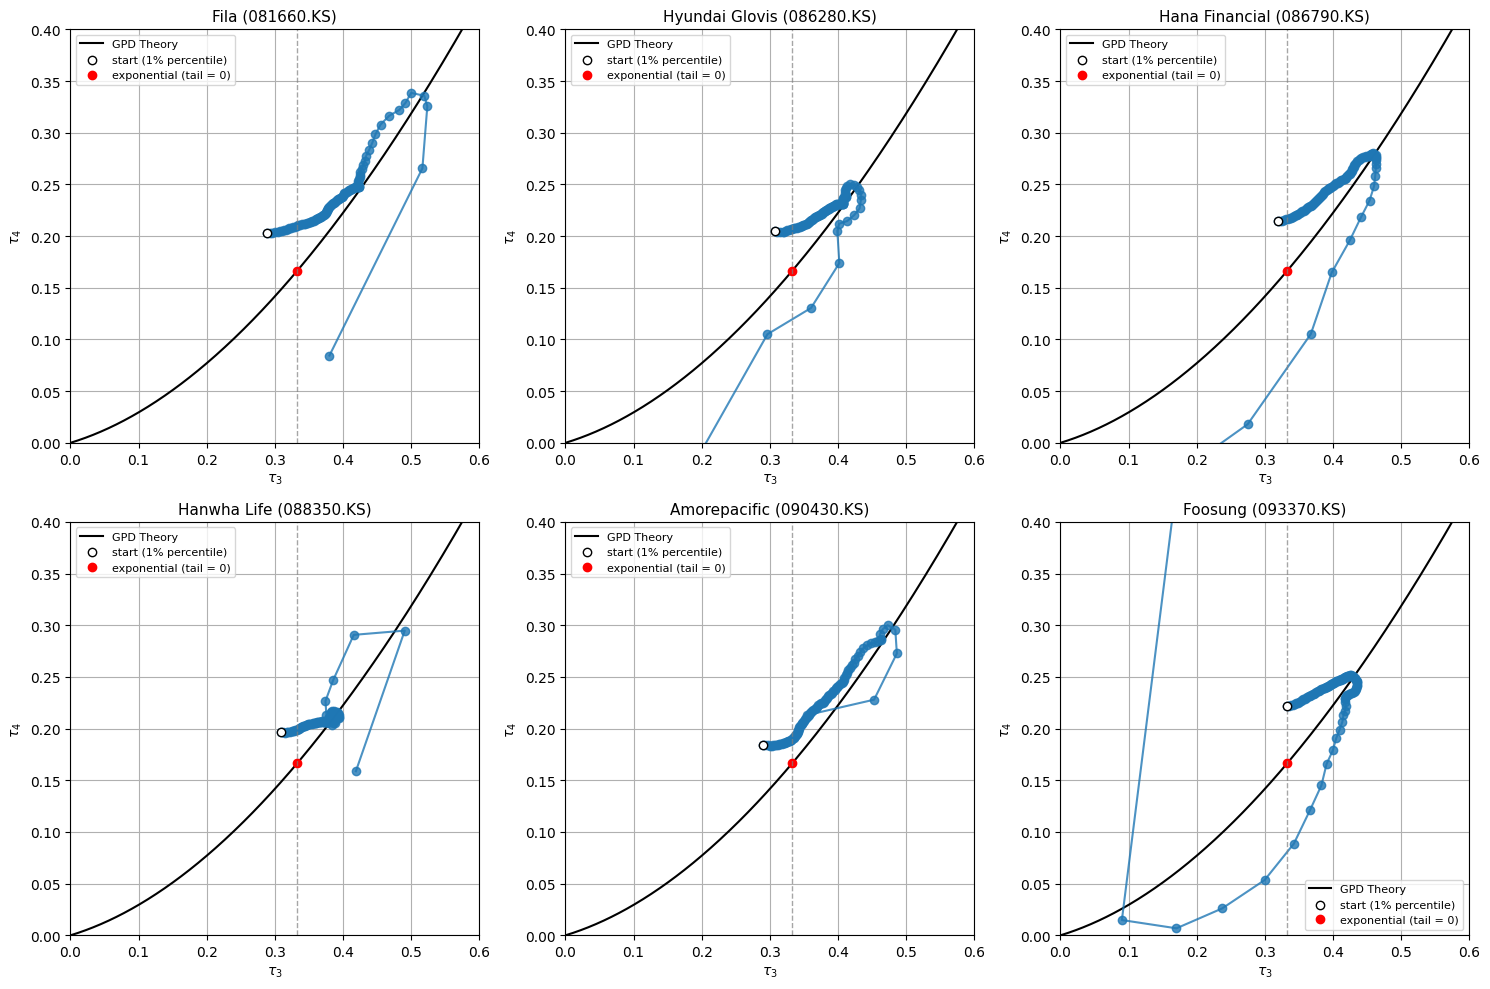

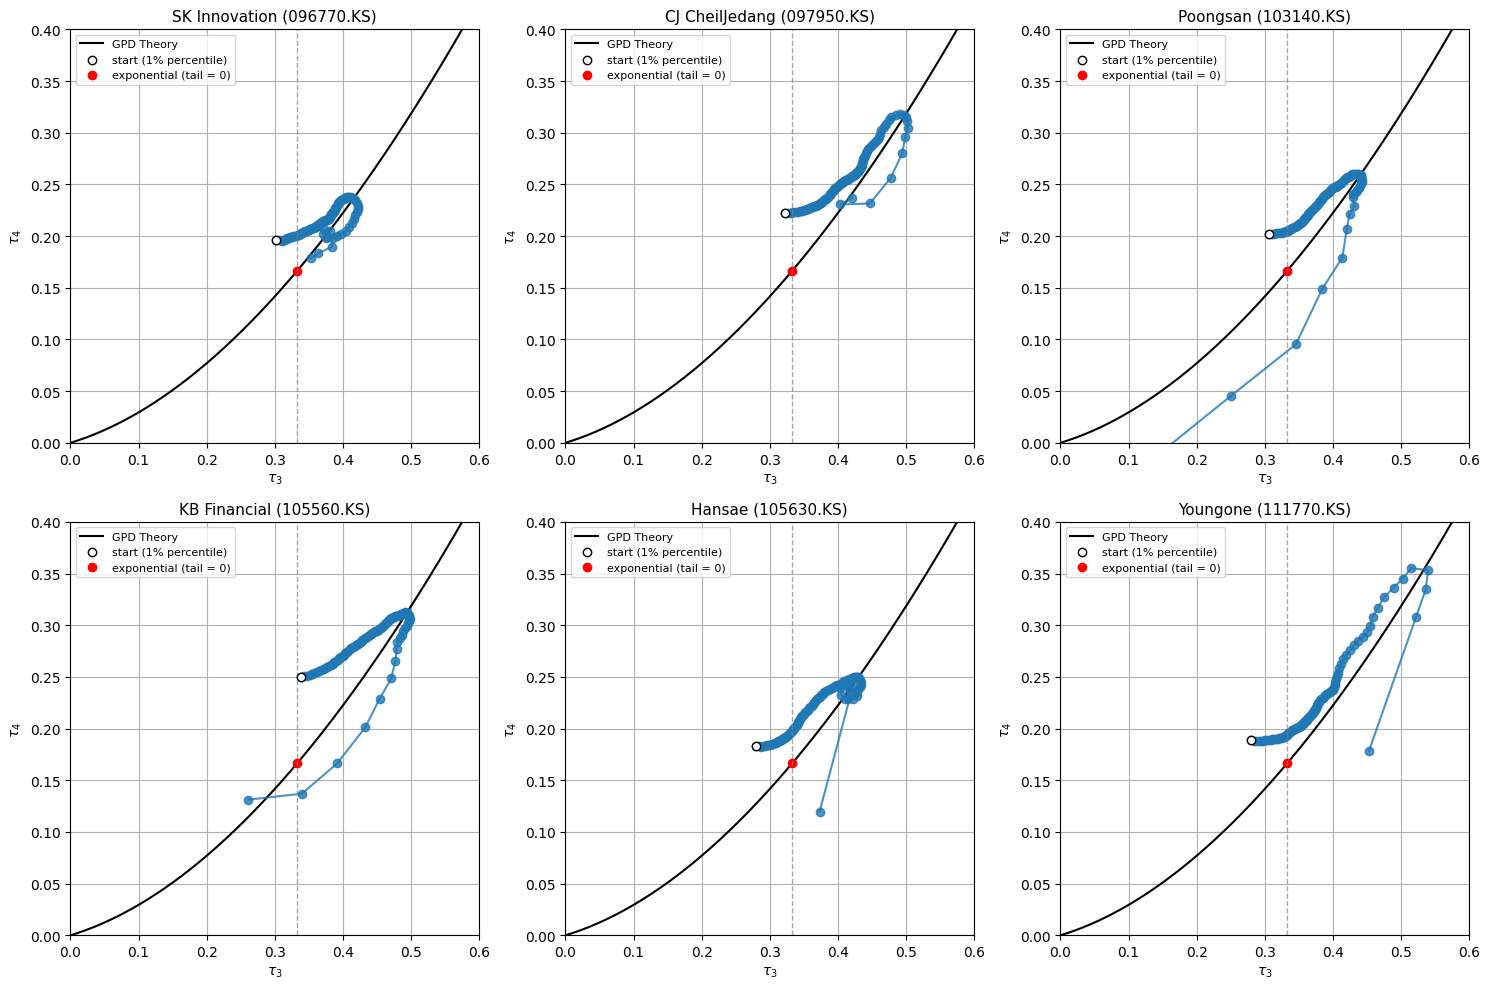

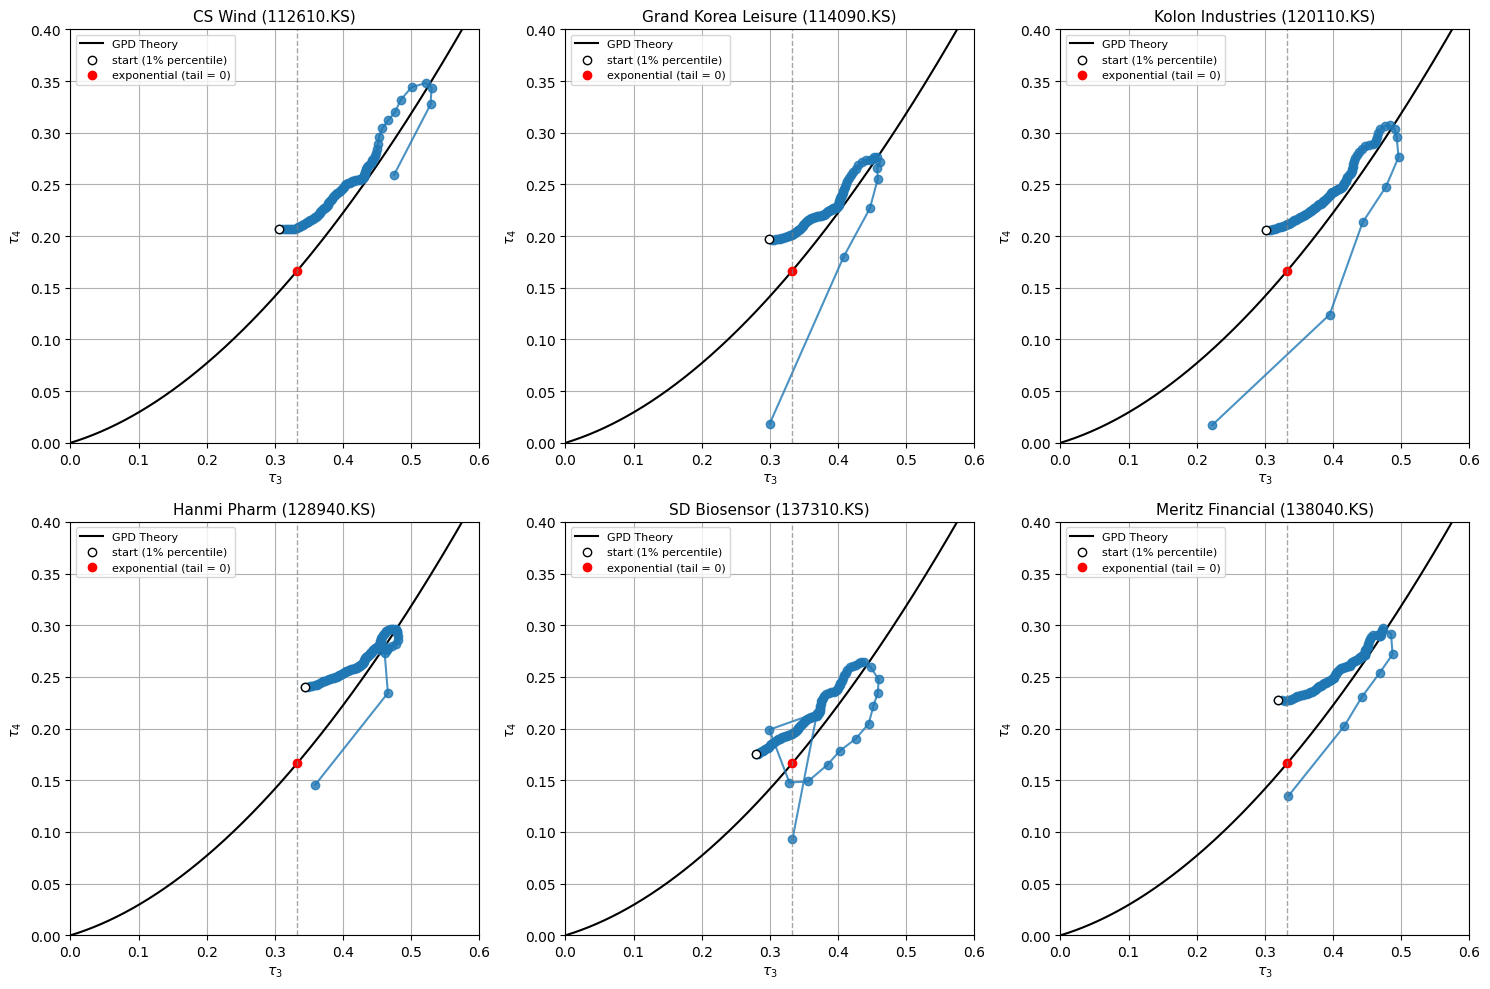

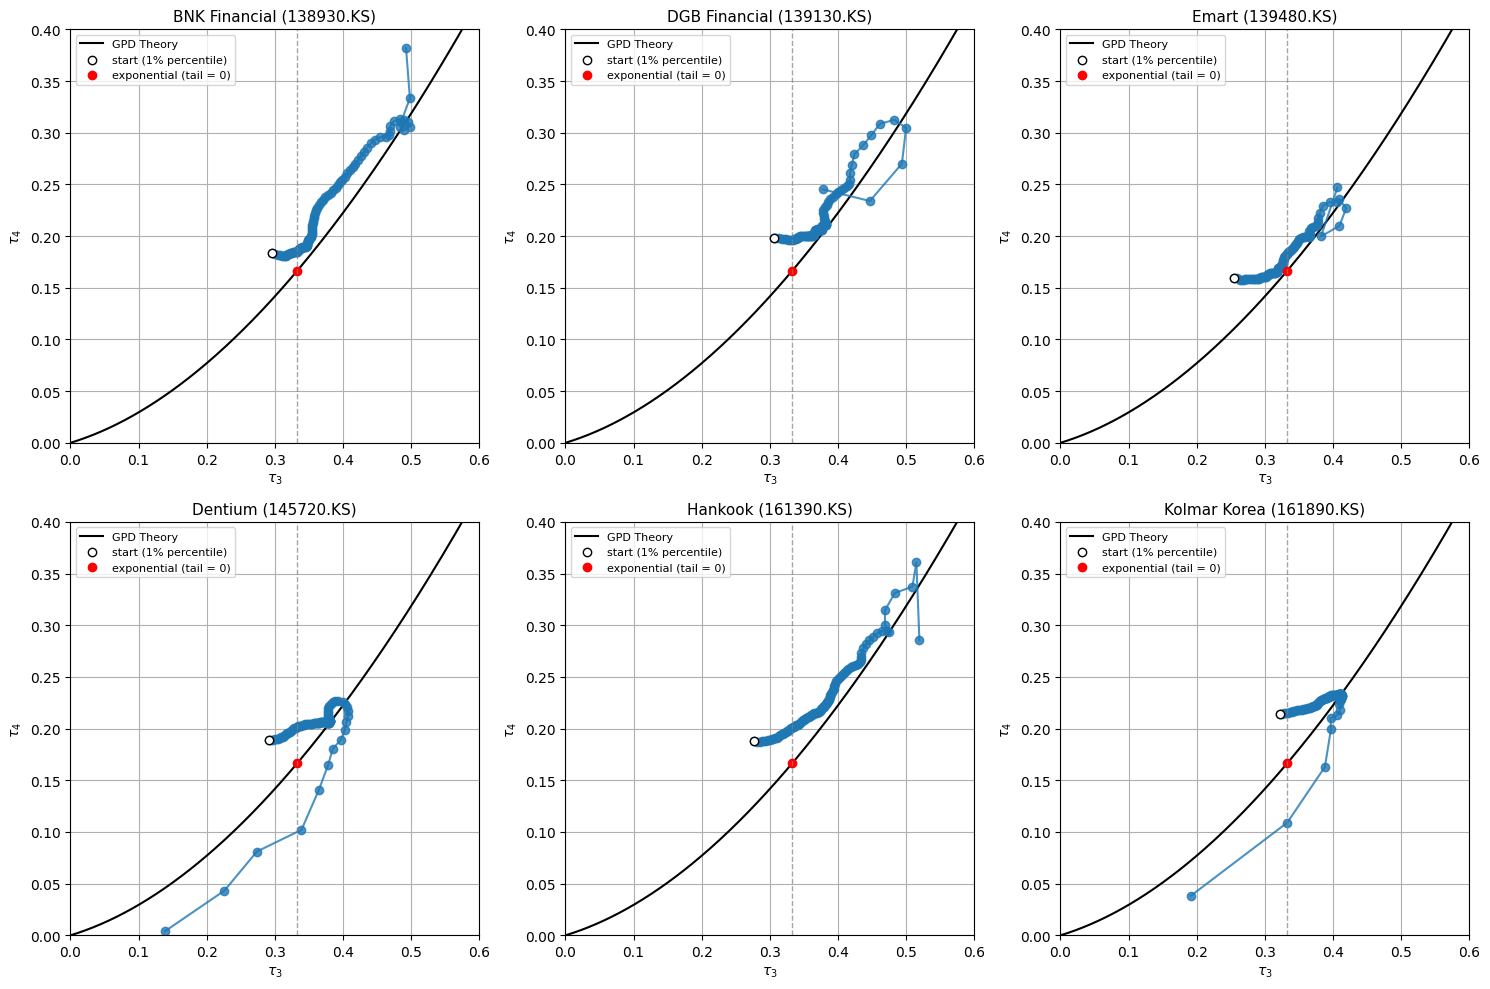

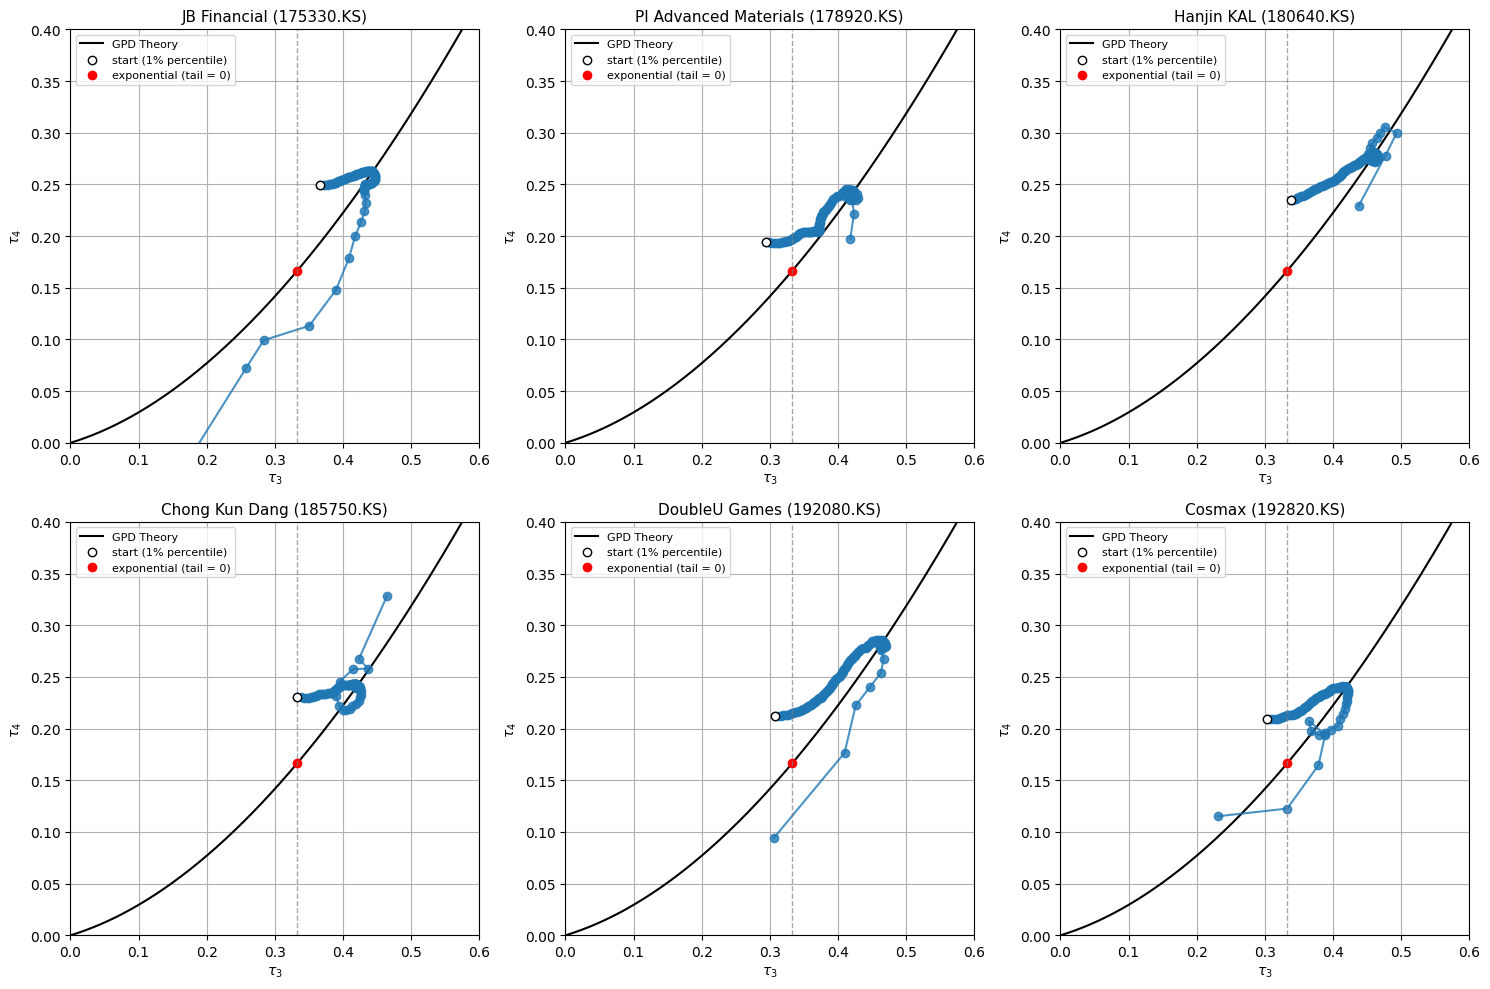

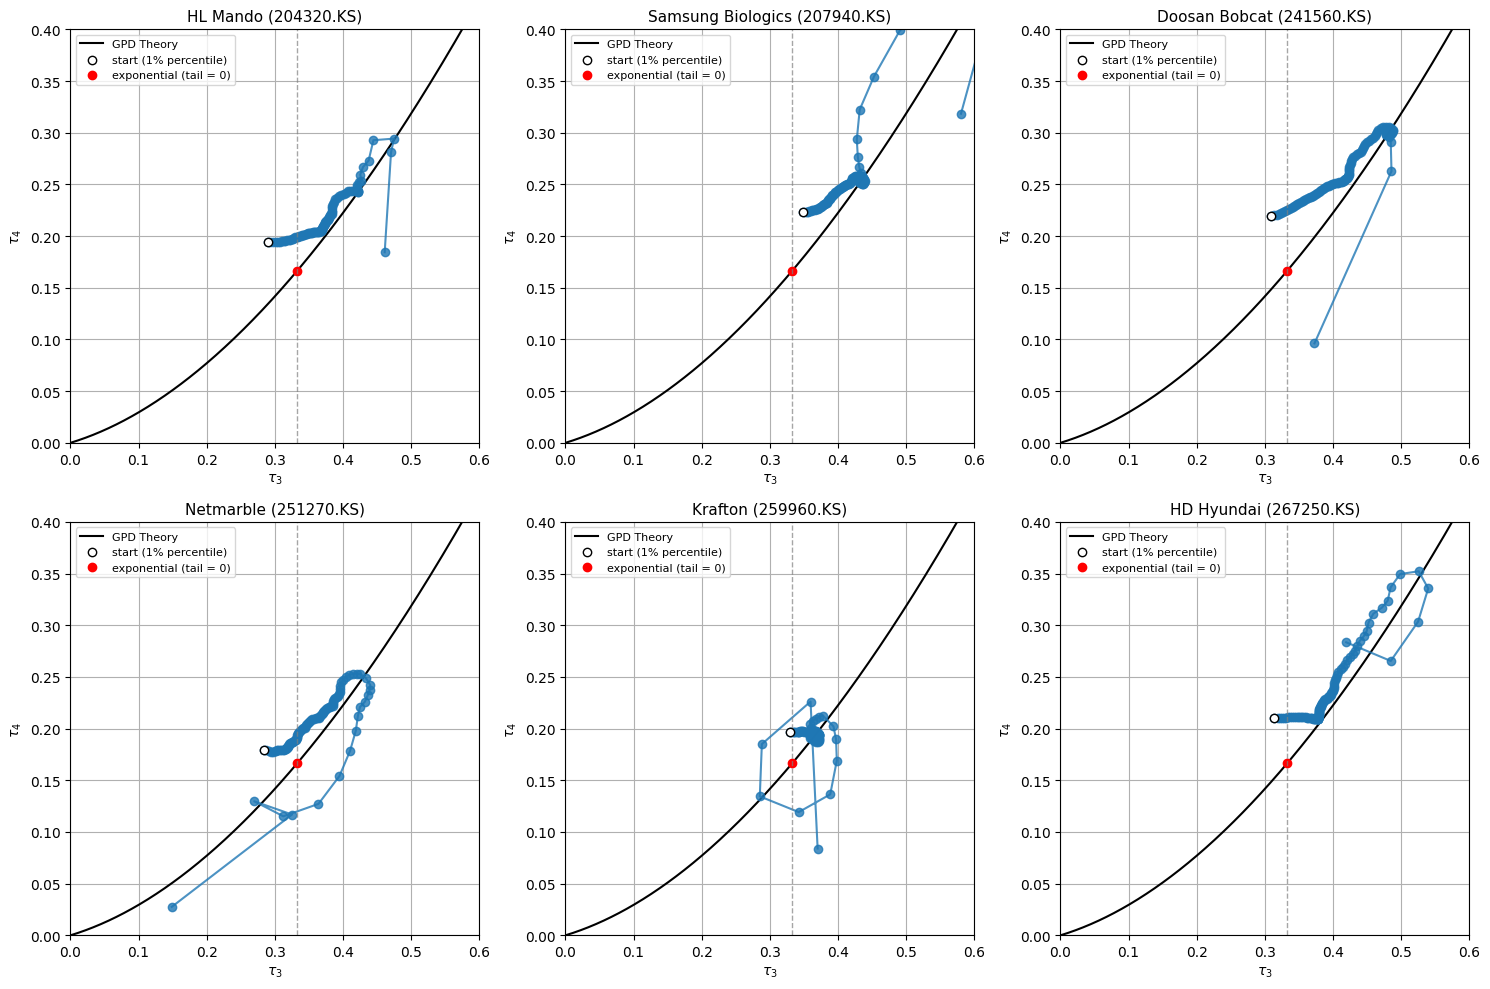

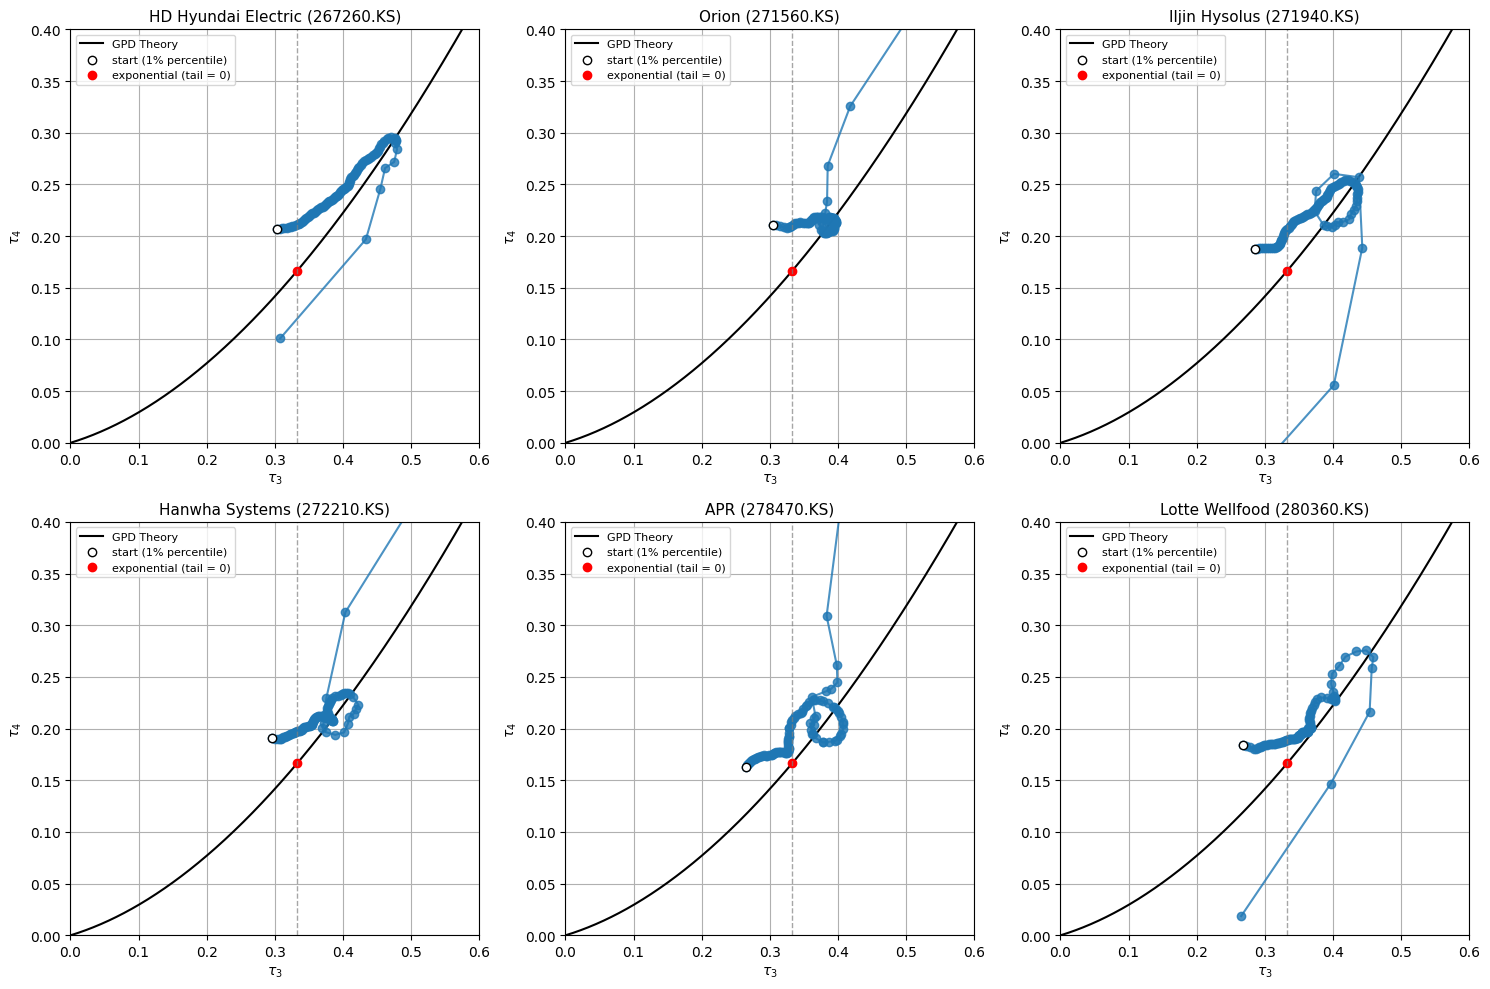

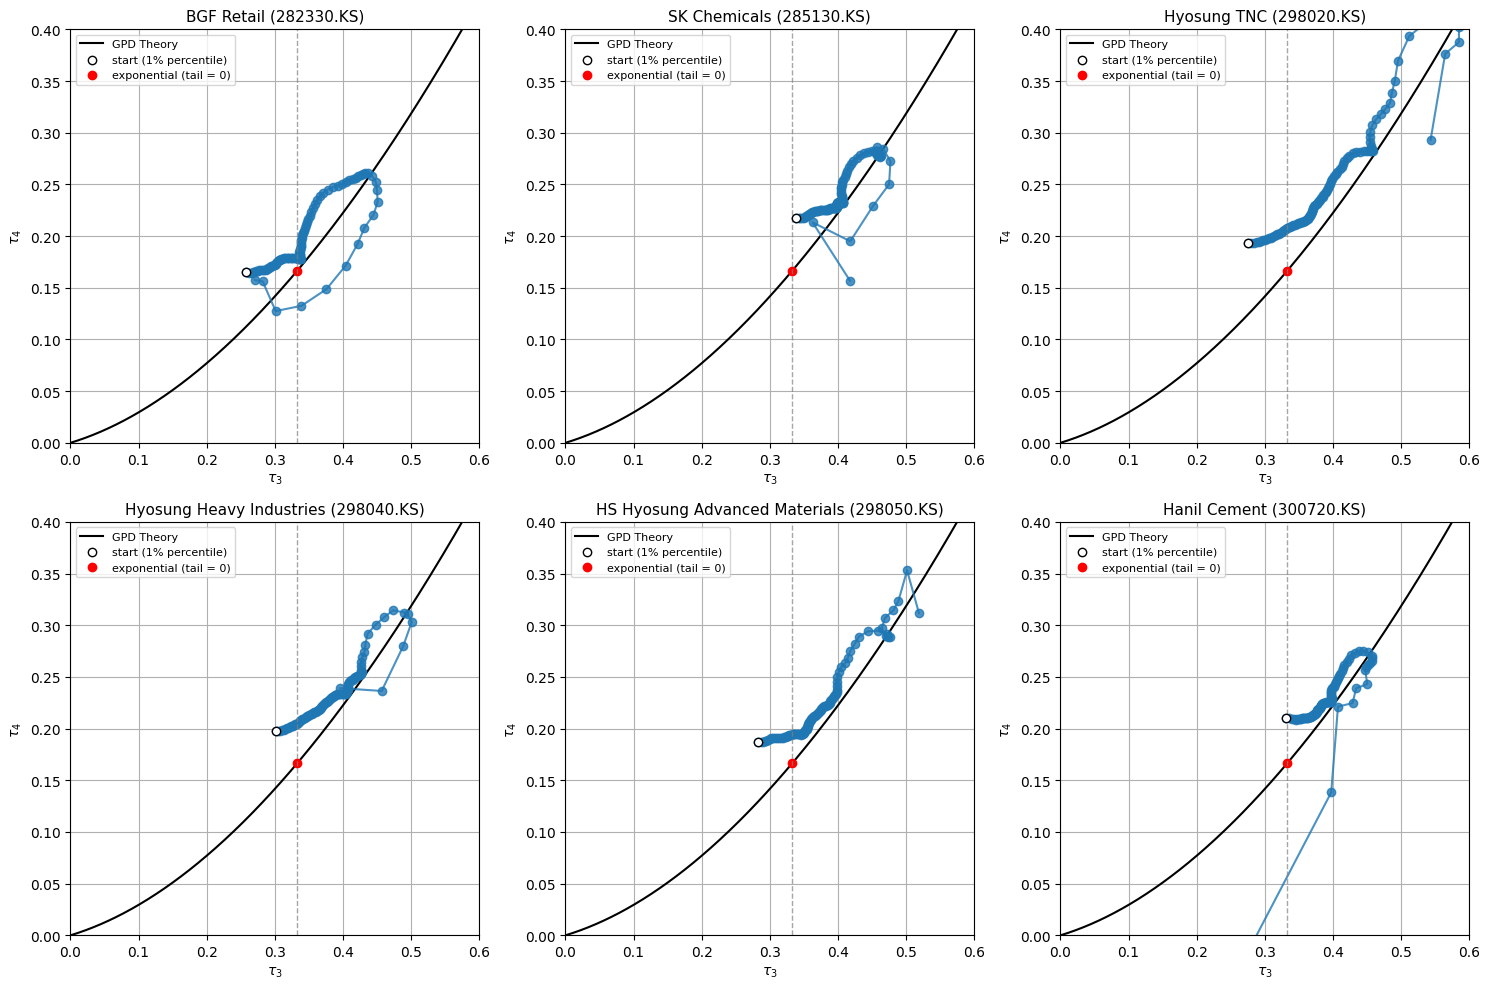

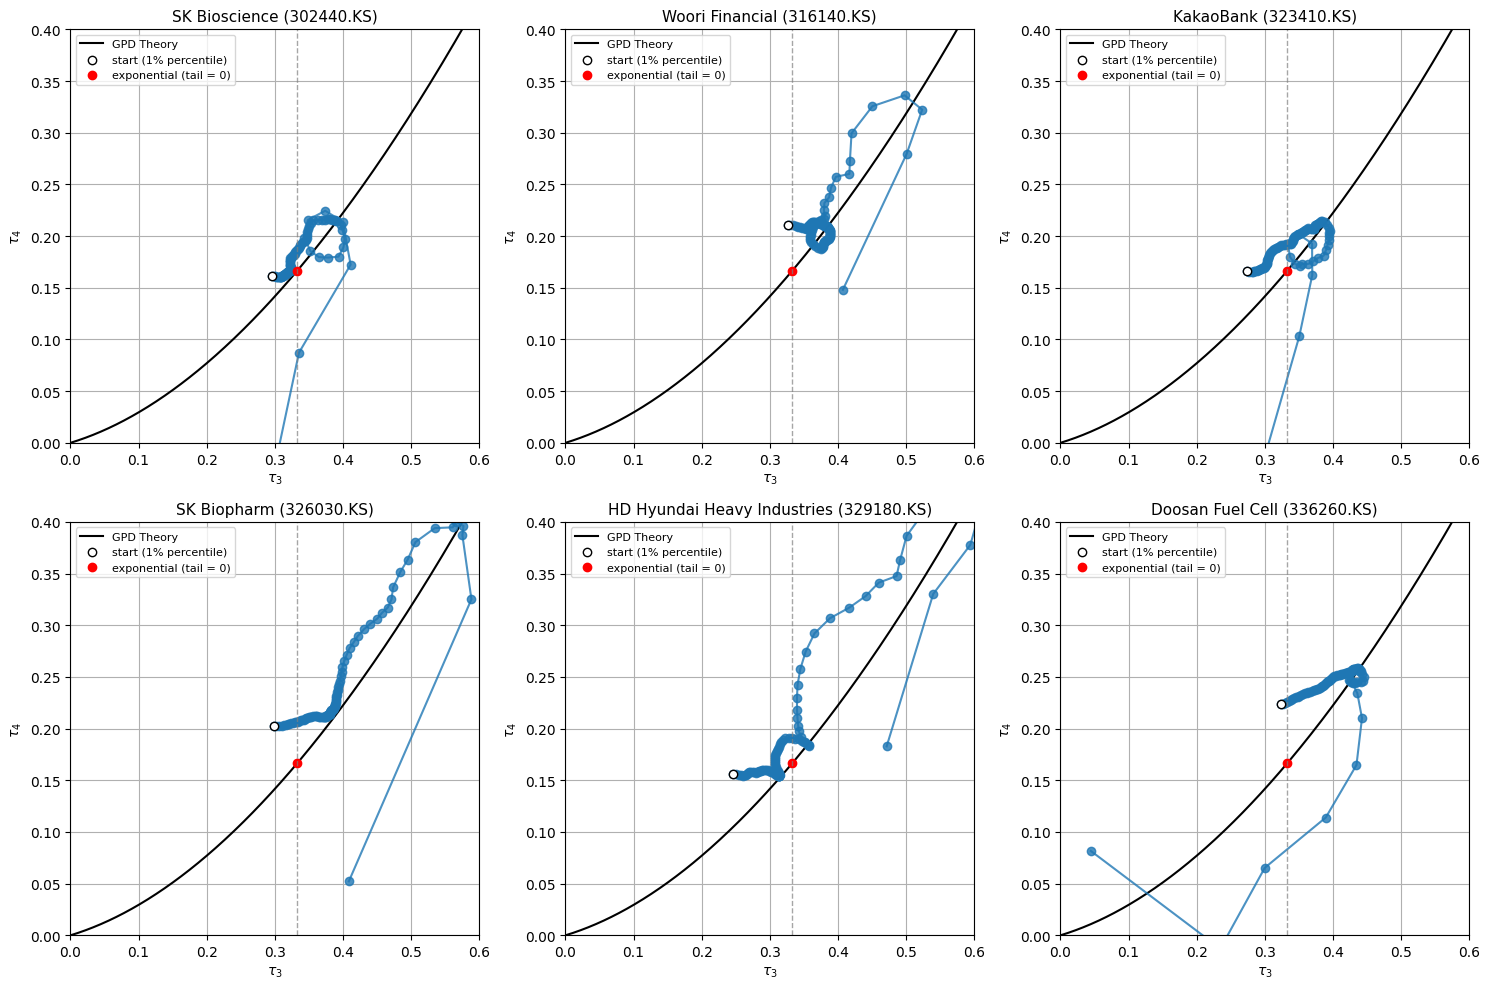

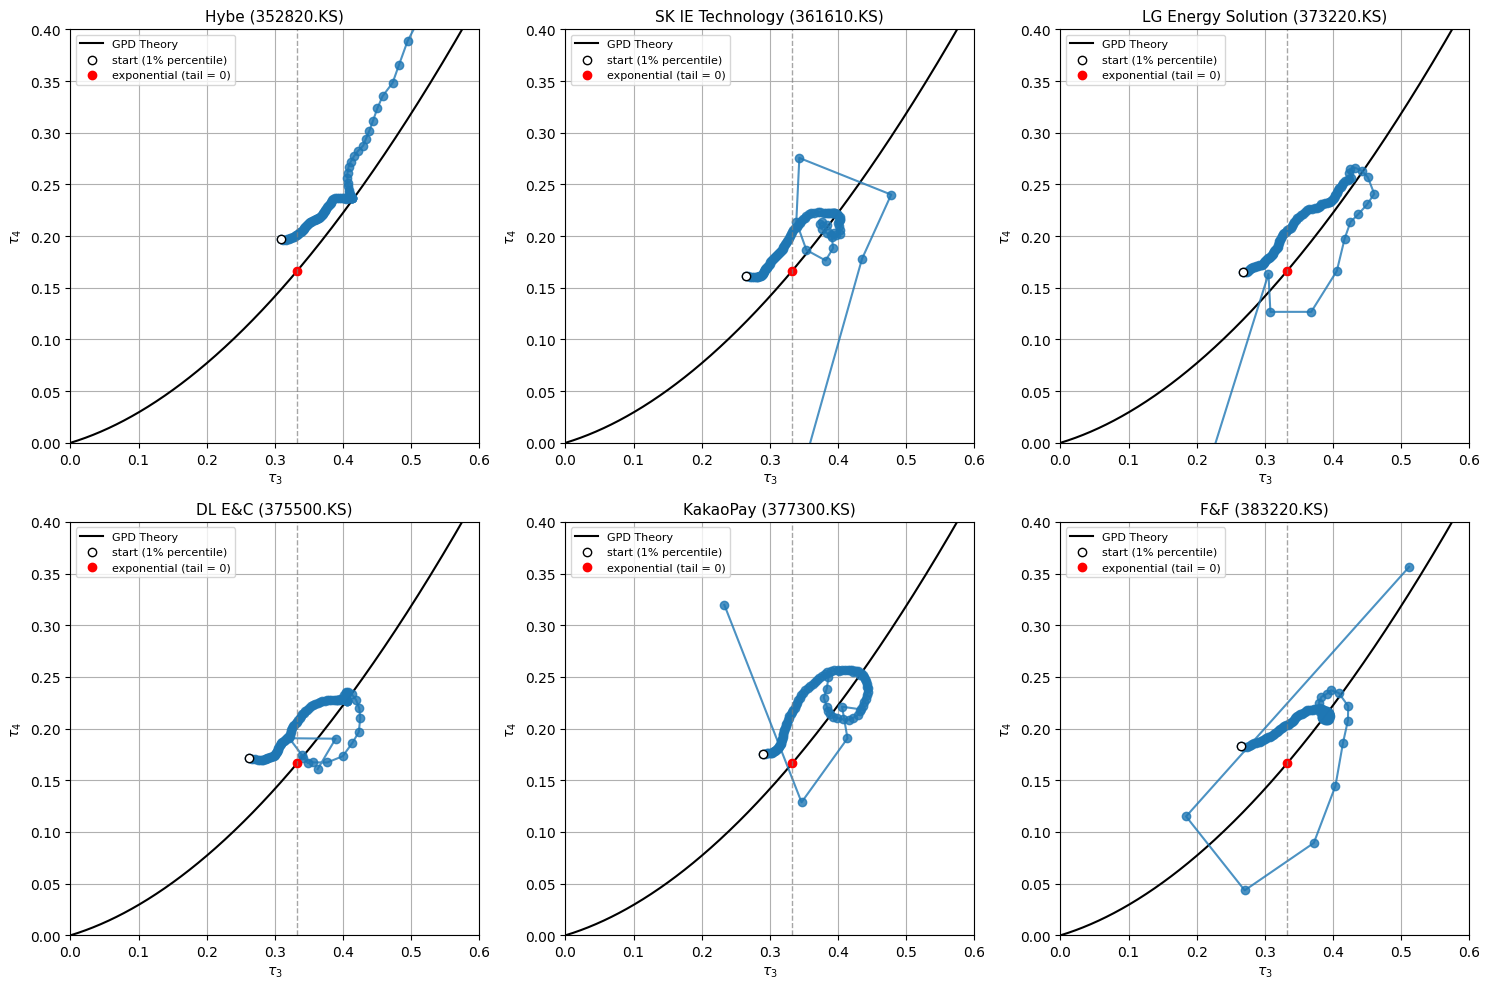

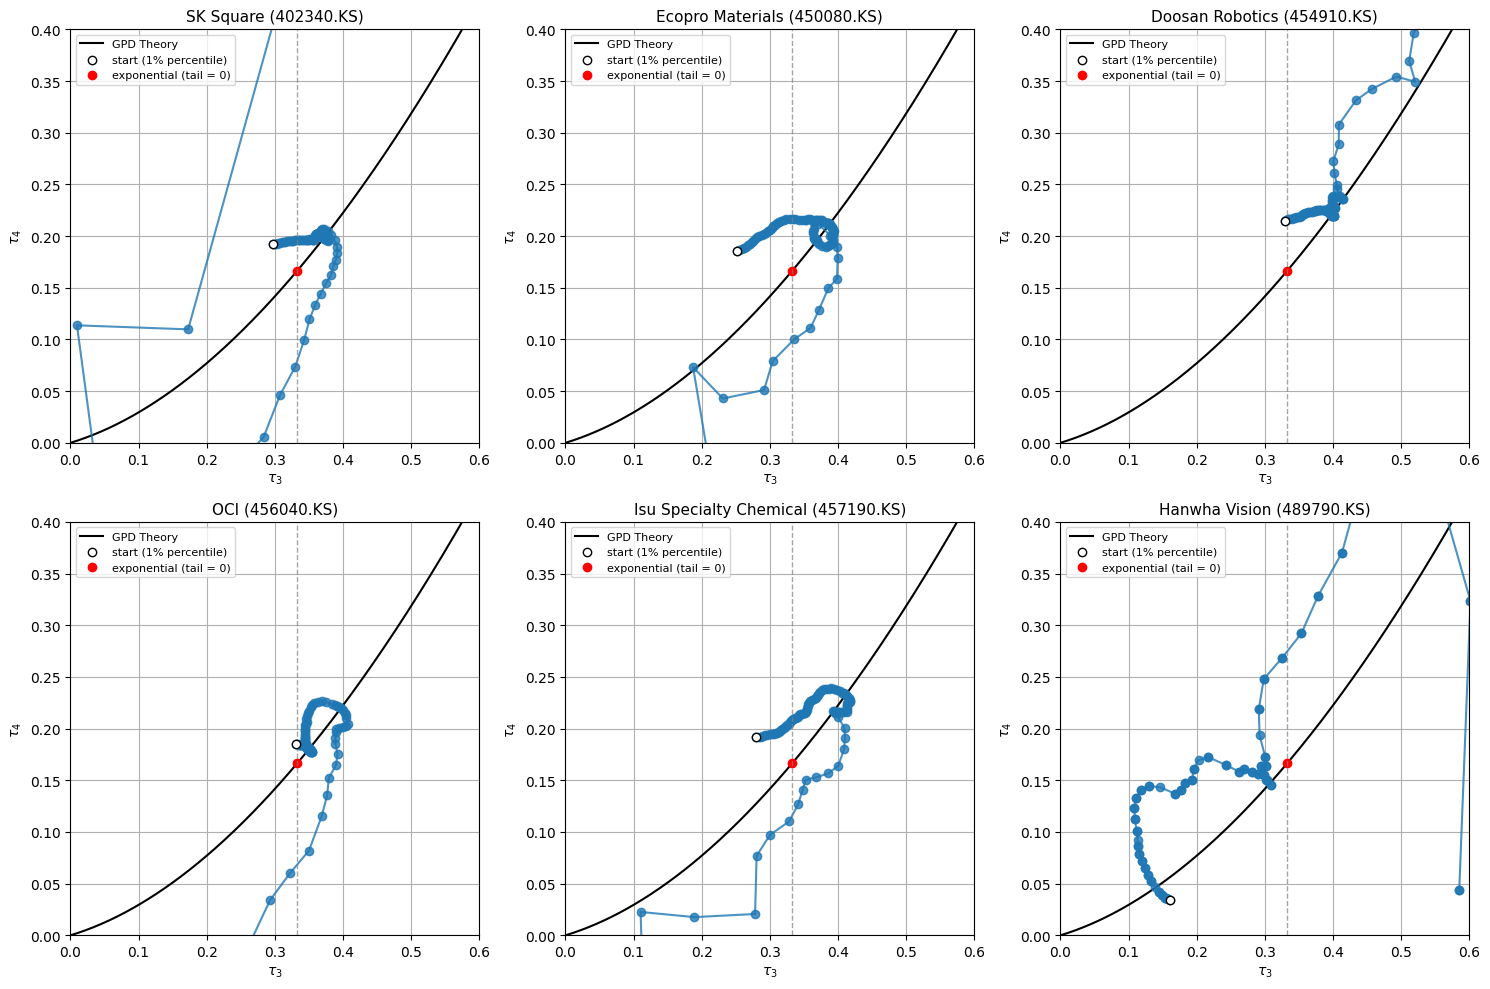

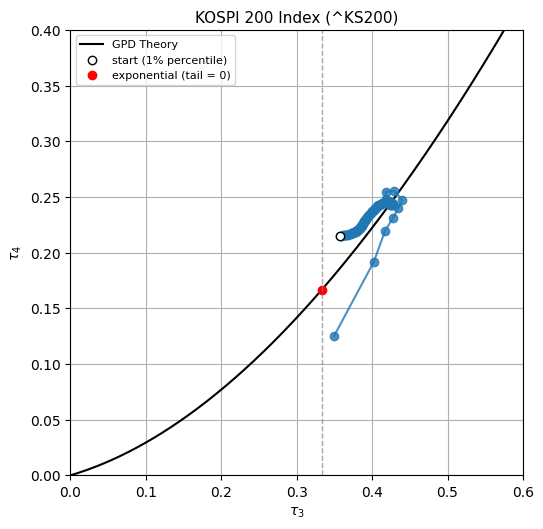

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

df_lmoment = pd.read_csv("lmoment_results.csv")
tickers = df_lmoment["Ticker"].unique()

with PdfPages("hosking_diagrams_LMO2.pdf") as pdf:
    for i in range(0, len(tickers), 6):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for j, ticker in enumerate(tickers[i:i+6]):
            ax = axes[j]
            subset = df_lmoment[df_lmoment["Ticker"] == ticker].sort_values("Quantile")

            # Plot GPD theory
            ax.plot(tau3_theory, tau4_theory, 'k-', label='GPD Theory')

            # Plot τ₃–τ₄ trajectory
            ax.plot(subset["tau3"], subset["tau4"],
                    marker="o",
                    linestyle='-', alpha=0.8)

            if not subset.empty:
                ax.scatter(subset["tau3"].iloc[0], subset["tau4"].iloc[0],
                        color='white', edgecolor='black', zorder=5, label=r"start (1% percentile)")
                ax.plot(1/3, 1/6, 'ro', label="exponential (tail = 0)")  # exponential reference point
                ax.axvline(x=1/3, color='gray', linestyle='--', linewidth=1, alpha=0.7)

            ax.set_title(f"{ticker_to_name[ticker]} ({ticker})", fontsize=11)
            ax.set_xlabel(r'$\tau_3$')
            ax.set_ylabel(r'$\tau_4$')
            ax.set_xlim(0.0, 0.6)
            ax.set_ylim(0.0, 0.4)
            ax.grid(True)
            ax.legend(fontsize=8)

        # Remove unused subplots
        for k in range(j + 1, 6):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close(fig)